## Prepare the inputs

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import scipy.misc
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')
import h5py
import cv2
import imageio

### Prepare data -- Training
dataset: choose train dataset or test dataset

Based on the paper, using a relatively small training set that consista 91 images. The size of training sub-images is 33, thus the 91-image dataset can be decomposed into 24800 sub-images, which are extracted from original iamges with a stride of 14.

In [9]:
image_size = 33
label_size = 21
scale = 3
stride = 14
c_dim = 1

In [15]:
# Load data path
dataset = './HR_CE'
data_dir = os.path.join(os.getcwd(), dataset)
data = glob.glob(os.path.join(data_dir, "*.jpg"))

In [16]:
def preprocess(path, scale):
    """
    Preprocess single image file:
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
    
    Args:
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
    """
    image = imread(path, is_grayscale=True)
    label_ = modcrop(image,scale)
    
    #Normalized
    image = image / 255
    label_ = label_ / 255
    
    input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
    
    return input_, label_

In [17]:

def imread(path, is_grayscale=True):
    if is_grayscale:
        return  imageio.imread(path, as_gray=True, pilmode='RGB').astype(np.float)
    else:
        return  imageio.pyplot.imread(path, pilmode='RGB').astype(np.float)

In [18]:
def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

### Display Input and Groundtruth

(480, 318)
(480, 318)


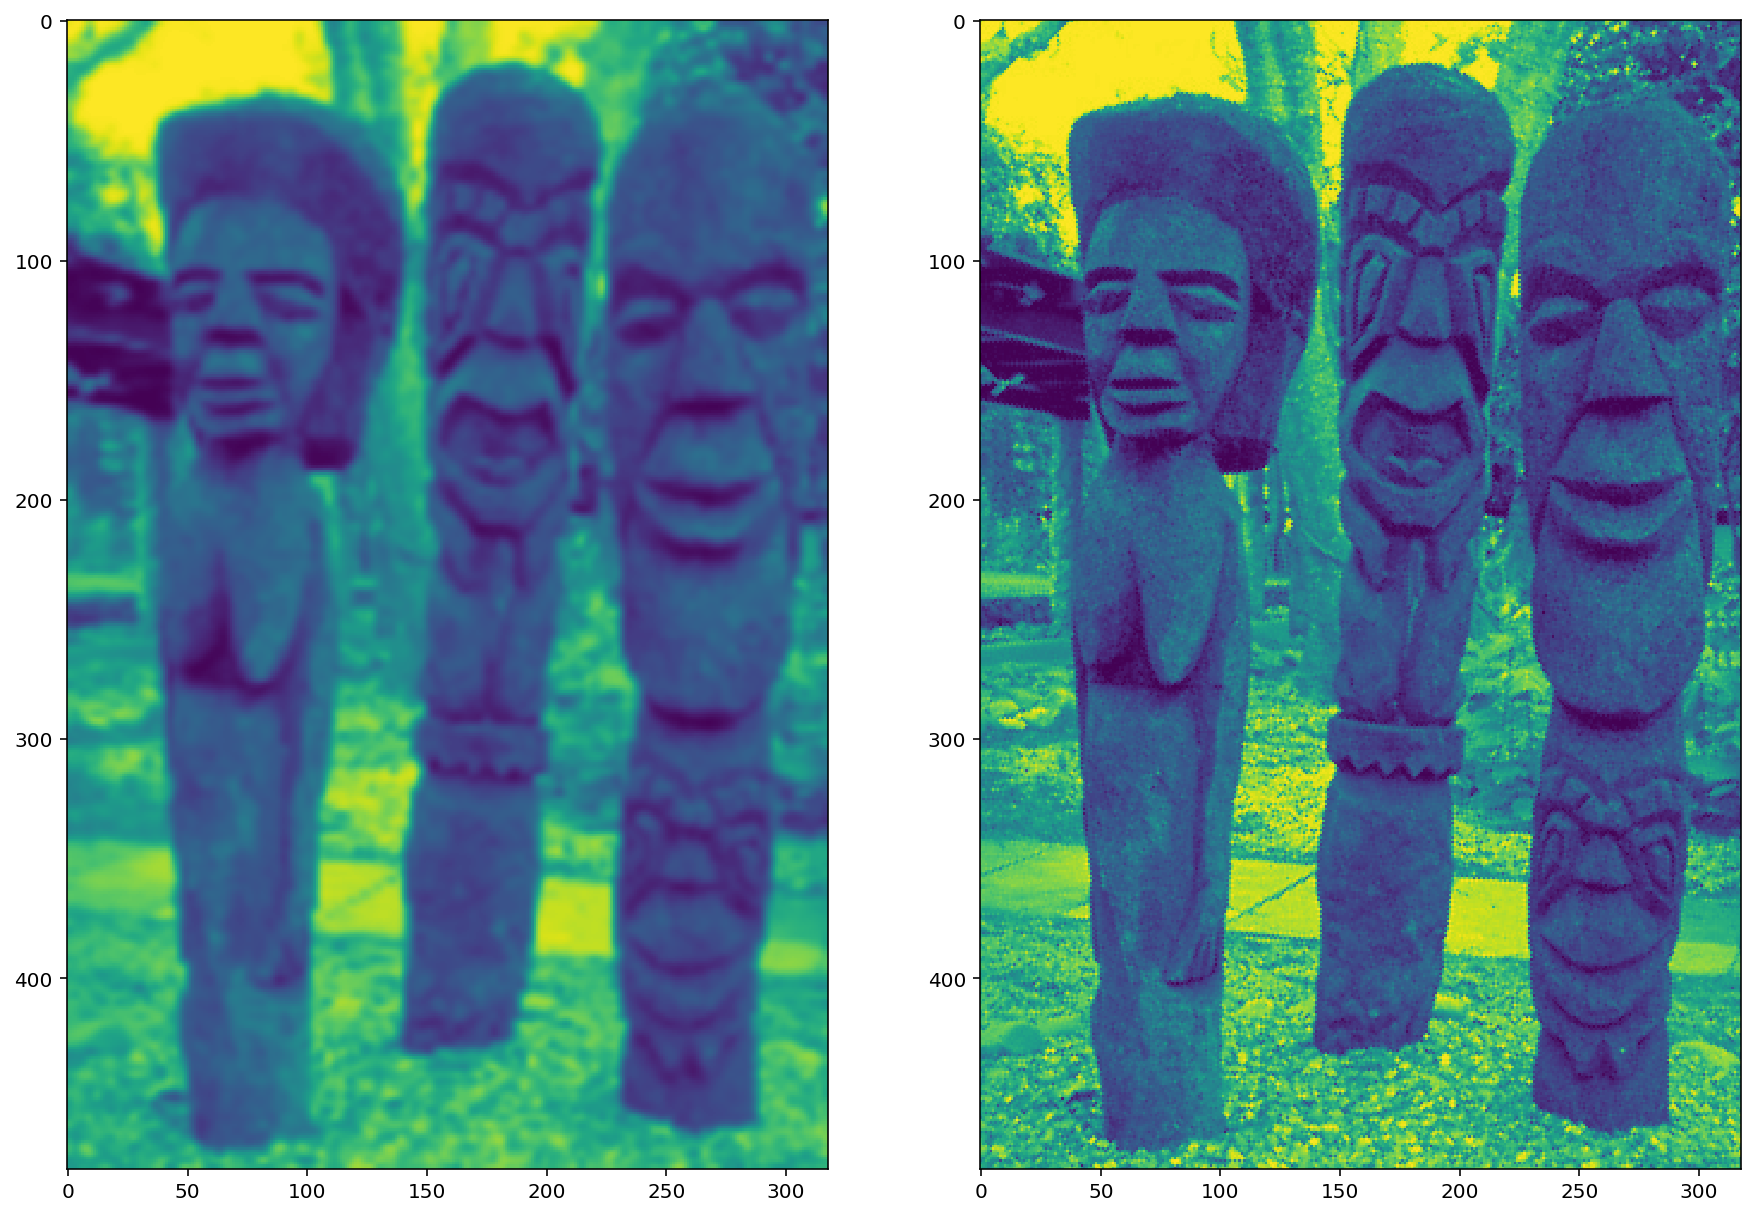

In [19]:
input_, label_ = preprocess(data[0], scale)
plt.figure(figsize=(15,15))
for i, image in enumerate([input_,label_]):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)

### Read image files and make their sub-images and save them as a h5 file format

In [20]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(image_size - label_size)/2)

for i in range(len(data)):
    if i%10 == 0:
        input_, label_ = preprocess(data[i], scale)
        if len(input_.shape)==3:
            h,w,_ = input_.shape
        else:
            h,w = input_.shape
        
        for x in range(0, h-image_size+1, stride):
            for y in range(0, w-image_size+1, stride):
                sub_input=input_[x:x+image_size,y:y+image_size] # 31x31
                sub_label=label_[x+padding:x+padding+label_size, y+padding:y+padding+label_size] # 21x21
        
                # Add Channel Value
                sub_input = sub_input.reshape([image_size, image_size, 1])
                sub_label = sub_label.reshape([label_size, label_size, 1])
                
                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)
                

In [49]:
"""
the number of sub_input (33 x 33 x ch) in one image
"""
len(sub_input_sequence)

0

In [22]:
"""
Make list to numpy array
"""
arrdata = np.asarray(sub_input_sequence)
arrlabel = np.asarray(sub_label_sequence)

In [23]:
arrdata.shape

(6720, 33, 33, 1)

In [24]:
"""
Make input data as h5 file format
"""
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')
savepath = os.path.join(os.getcwd(), 'checkpoint/train.h5')
with h5py.File(savepath, 'w') as hf:
    hf.create_dataset('data', data=arrdata)
    hf.create_dataset('label', data=arrlabel)

### Checkpoint
The preprocessed data has been saved to disk.

In [25]:
data_dir = os.path.join('./{}'.format('checkpoint'), "train.h5")

def read_data(path):
    with h5py.File(path, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        return data, label
train_data, train_label = read_data(data_dir)

## Build the network

In [26]:
import tensorflow as tf

In [27]:
"""
Inputs:
"""
images = tf.placeholder(tf.float32,[None, image_size, image_size, c_dim], name='images')
labels = tf.placeholder(tf.float32,[None, label_size, label_size, c_dim], name='labels')

In [28]:
"""
Weights and Biases:
"""
weights = {
    'w1': tf.Variable(tf.random_normal([9,9,1,64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5,5,32,1], stddev=1e-3), name='w3')
}
biases = {
    'b1': tf.Variable(tf.zeros([64]), name='b1'),
    'b2': tf.Variable(tf.zeros([32]), name='b2'),
    'b3': tf.Variable(tf.zeros([1]),name='b3')
}

In [29]:
"""
Model:
"""
conv1 = tf.nn.relu(tf.nn.conv2d(images, 
                                weights['w1'], 
                                strides=[1,1,1,1], 
                                padding='VALID')+biases['b1'])
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, 
                                weights['w2'], 
                                strides=[1,1,1,1], 
                                padding='VALID')+biases['b2'])
conv3 = tf.nn.relu(tf.nn.conv2d(conv2, 
                                weights['w3'], 
                                strides=[1,1,1,1], 
                                padding='VALID')+biases['b3'])
pred = conv3

In [30]:
"""
Loss function (MSE)
"""
loss = tf.reduce_mean(tf.square(labels - pred))

saver = tf.train.Saver()

## Train the network

In [33]:
learning_rate = 1e-4
epoch = 100
batch_size = 64

In [34]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [35]:
import time

In [36]:
print('Checking the Training on a single batch...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    counter = 0
    start_time = time.time()
    
    for ep in range(epoch):
        batch_idxs = len(train_data) // batch_size
        for idx in range(0, batch_idxs):
            batch_images = train_data[idx*batch_size : (idx+1)*batch_size]
            batch_labels = train_label[idx*batch_size : (idx+1)*batch_size]
            
            counter += 1
            _, err = sess.run([train_op, loss], feed_dict={images: batch_images, labels: batch_labels})
            
            
            print("Epoch: [%2d], step: [%2d], time: [%4.4f], loss: [%.8f]"%((ep+1), counter, time.time()-start_time, err))

            if counter % 20 == 0:
                
                model_name = "SRCNN.model"
                model_dir = "%s_%s" % ("srcnn", label_size)
                checkpoint_dir = os.path.join('checkpoint', model_dir)

                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=counter)

Checking the Training on a single batch...
Epoch: [ 1], step: [ 1], time: [0.3297], loss: [0.44623128]
Epoch: [ 1], step: [ 2], time: [0.5241], loss: [0.13962053]
Epoch: [ 1], step: [ 3], time: [0.7196], loss: [0.06970777]
Epoch: [ 1], step: [ 4], time: [0.9180], loss: [0.08537144]
Epoch: [ 1], step: [ 5], time: [1.1245], loss: [0.11634579]
Epoch: [ 1], step: [ 6], time: [1.3239], loss: [0.13445228]
Epoch: [ 1], step: [ 7], time: [1.5163], loss: [0.18620615]
Epoch: [ 1], step: [ 8], time: [1.7097], loss: [0.22494140]
Epoch: [ 1], step: [ 9], time: [1.9062], loss: [0.27863109]
Epoch: [ 1], step: [10], time: [2.1046], loss: [0.26251146]
Epoch: [ 1], step: [11], time: [2.2970], loss: [0.30422971]
Epoch: [ 1], step: [12], time: [2.4854], loss: [0.33231443]
Epoch: [ 1], step: [13], time: [2.6799], loss: [0.32499754]
Epoch: [ 1], step: [14], time: [2.8753], loss: [0.29658803]
Epoch: [ 1], step: [15], time: [3.0777], loss: [0.30190408]
Epoch: [ 1], step: [16], time: [3.2661], loss: [0.2175799

Epoch: [ 2], step: [136], time: [29.3802], loss: [0.57435900]
Epoch: [ 2], step: [137], time: [29.5736], loss: [0.39663476]
Epoch: [ 2], step: [138], time: [29.7650], loss: [0.26367733]
Epoch: [ 2], step: [139], time: [29.9584], loss: [0.24928430]
Epoch: [ 2], step: [140], time: [30.1529], loss: [0.26716504]
Epoch: [ 2], step: [141], time: [30.8484], loss: [0.24872811]
Epoch: [ 2], step: [142], time: [31.0398], loss: [0.23664902]
Epoch: [ 2], step: [143], time: [31.2372], loss: [0.19585001]
Epoch: [ 2], step: [144], time: [31.4357], loss: [0.17222962]
Epoch: [ 2], step: [145], time: [31.6341], loss: [0.19068252]
Epoch: [ 2], step: [146], time: [31.8255], loss: [0.20622487]
Epoch: [ 2], step: [147], time: [32.0199], loss: [0.28298602]
Epoch: [ 2], step: [148], time: [32.2124], loss: [0.58298314]
Epoch: [ 2], step: [149], time: [32.4118], loss: [0.17475992]
Epoch: [ 2], step: [150], time: [32.6012], loss: [0.27002093]
Epoch: [ 2], step: [151], time: [32.7986], loss: [0.33497816]
Epoch: [

Epoch: [ 3], step: [269], time: [58.3464], loss: [0.28571478]
Epoch: [ 3], step: [270], time: [58.5389], loss: [0.24832509]
Epoch: [ 3], step: [271], time: [58.7333], loss: [0.40474921]
Epoch: [ 3], step: [272], time: [58.9327], loss: [0.59082240]
Epoch: [ 3], step: [273], time: [59.1282], loss: [0.51647210]
Epoch: [ 3], step: [274], time: [59.3176], loss: [0.12249149]
Epoch: [ 3], step: [275], time: [59.5060], loss: [0.14085317]
Epoch: [ 3], step: [276], time: [59.7054], loss: [0.14870040]
Epoch: [ 3], step: [277], time: [59.8998], loss: [0.16171299]
Epoch: [ 3], step: [278], time: [60.0933], loss: [0.15965638]
Epoch: [ 3], step: [279], time: [60.2957], loss: [0.16052704]
Epoch: [ 3], step: [280], time: [60.4901], loss: [0.17763592]
Epoch: [ 3], step: [281], time: [61.1466], loss: [0.22564846]
Epoch: [ 3], step: [282], time: [61.3420], loss: [0.17913251]
Epoch: [ 3], step: [283], time: [61.5354], loss: [0.16553135]
Epoch: [ 3], step: [284], time: [61.7318], loss: [0.15354364]
Epoch: [

Epoch: [ 4], step: [403], time: [87.8018], loss: [0.00638292]
Epoch: [ 4], step: [404], time: [88.0002], loss: [0.02398843]
Epoch: [ 4], step: [405], time: [88.2017], loss: [0.04913703]
Epoch: [ 4], step: [406], time: [88.3911], loss: [0.07818095]
Epoch: [ 4], step: [407], time: [88.5785], loss: [0.12739153]
Epoch: [ 4], step: [408], time: [88.7699], loss: [0.10233459]
Epoch: [ 4], step: [409], time: [88.9633], loss: [0.02245596]
Epoch: [ 4], step: [410], time: [89.1527], loss: [0.21807310]
Epoch: [ 4], step: [411], time: [89.3482], loss: [0.30637267]
Epoch: [ 4], step: [412], time: [89.5356], loss: [0.22934480]
Epoch: [ 4], step: [413], time: [89.7350], loss: [0.19658251]
Epoch: [ 4], step: [414], time: [89.9244], loss: [0.22324155]
Epoch: [ 4], step: [415], time: [90.1199], loss: [0.19791086]
Epoch: [ 4], step: [416], time: [90.3123], loss: [0.16437082]
Epoch: [ 4], step: [417], time: [90.5087], loss: [0.07568350]
Epoch: [ 4], step: [418], time: [90.7001], loss: [0.07362876]
Epoch: [

Epoch: [ 6], step: [535], time: [116.0104], loss: [0.22583154]
Epoch: [ 6], step: [536], time: [116.2078], loss: [0.26402801]
Epoch: [ 6], step: [537], time: [116.4083], loss: [0.29051024]
Epoch: [ 6], step: [538], time: [116.6027], loss: [0.28424415]
Epoch: [ 6], step: [539], time: [116.7991], loss: [0.25908706]
Epoch: [ 6], step: [540], time: [116.9946], loss: [0.26457486]
Epoch: [ 6], step: [541], time: [117.6440], loss: [0.18934983]
Epoch: [ 6], step: [542], time: [117.8344], loss: [0.13538375]
Epoch: [ 6], step: [543], time: [118.0328], loss: [0.15011843]
Epoch: [ 6], step: [544], time: [118.2292], loss: [0.08501007]
Epoch: [ 6], step: [545], time: [118.4227], loss: [0.12883453]
Epoch: [ 6], step: [546], time: [118.6121], loss: [0.34670380]
Epoch: [ 6], step: [547], time: [118.8085], loss: [0.16874391]
Epoch: [ 6], step: [548], time: [119.0079], loss: [0.18570687]
Epoch: [ 6], step: [549], time: [119.2044], loss: [0.14362380]
Epoch: [ 6], step: [550], time: [119.3938], loss: [0.40

Epoch: [ 7], step: [667], time: [144.6810], loss: [0.19971840]
Epoch: [ 7], step: [668], time: [144.8765], loss: [0.16343077]
Epoch: [ 7], step: [669], time: [145.0749], loss: [0.14267051]
Epoch: [ 7], step: [670], time: [145.2653], loss: [0.15904963]
Epoch: [ 7], step: [671], time: [145.4597], loss: [0.17290568]
Epoch: [ 7], step: [672], time: [145.6542], loss: [0.24265277]
Epoch: [ 7], step: [673], time: [145.8566], loss: [0.52723539]
Epoch: [ 7], step: [674], time: [146.0500], loss: [0.14405794]
Epoch: [ 7], step: [675], time: [146.2475], loss: [0.23000206]
Epoch: [ 7], step: [676], time: [146.4469], loss: [0.29174951]
Epoch: [ 7], step: [677], time: [146.6453], loss: [0.27957803]
Epoch: [ 7], step: [678], time: [146.8327], loss: [0.32136405]
Epoch: [ 7], step: [679], time: [147.0312], loss: [0.23106779]
Epoch: [ 7], step: [680], time: [147.2206], loss: [0.14222917]
Epoch: [ 7], step: [681], time: [147.7998], loss: [0.11738019]
Epoch: [ 7], step: [682], time: [148.0033], loss: [0.13

Epoch: [ 8], step: [799], time: [172.9728], loss: [0.09621512]
Epoch: [ 8], step: [800], time: [173.1672], loss: [0.11265188]
Epoch: [ 8], step: [801], time: [173.7886], loss: [0.11988676]
Epoch: [ 8], step: [802], time: [173.9860], loss: [0.13184984]
Epoch: [ 8], step: [803], time: [174.1795], loss: [0.13018404]
Epoch: [ 8], step: [804], time: [174.3719], loss: [0.13123688]
Epoch: [ 8], step: [805], time: [174.5713], loss: [0.14693861]
Epoch: [ 8], step: [806], time: [174.7697], loss: [0.19026990]
Epoch: [ 8], step: [807], time: [174.9662], loss: [0.14752652]
Epoch: [ 8], step: [808], time: [175.1566], loss: [0.13499966]
Epoch: [ 8], step: [809], time: [175.3460], loss: [0.12416141]
Epoch: [ 8], step: [810], time: [175.5404], loss: [0.13317244]
Epoch: [ 8], step: [811], time: [175.7379], loss: [0.10943039]
Epoch: [ 8], step: [812], time: [175.9303], loss: [0.10300985]
Epoch: [ 8], step: [813], time: [176.1247], loss: [0.08963630]
Epoch: [ 8], step: [814], time: [176.3282], loss: [0.09

Epoch: [ 9], step: [931], time: [201.7577], loss: [0.06677234]
Epoch: [ 9], step: [932], time: [201.9511], loss: [0.11247022]
Epoch: [ 9], step: [933], time: [202.1465], loss: [0.08842146]
Epoch: [ 9], step: [934], time: [202.3460], loss: [0.01543170]
Epoch: [ 9], step: [935], time: [202.5454], loss: [0.19088924]
Epoch: [ 9], step: [936], time: [202.7408], loss: [0.26505420]
Epoch: [ 9], step: [937], time: [202.9353], loss: [0.19410703]
Epoch: [ 9], step: [938], time: [203.1327], loss: [0.16485444]
Epoch: [ 9], step: [939], time: [203.3281], loss: [0.18949716]
Epoch: [ 9], step: [940], time: [203.5236], loss: [0.16666326]
Epoch: [ 9], step: [941], time: [204.2040], loss: [0.13643901]
Epoch: [ 9], step: [942], time: [204.3955], loss: [0.05708941]
Epoch: [ 9], step: [943], time: [204.5959], loss: [0.05491463]
Epoch: [ 9], step: [944], time: [204.7873], loss: [0.09042867]
Epoch: [ 9], step: [945], time: [204.9857], loss: [0.10331304]
Epoch: [10], step: [946], time: [205.1852], loss: [0.36

Epoch: [11], step: [1061], time: [230.1357], loss: [0.23087189]
Epoch: [11], step: [1062], time: [230.3261], loss: [0.25591025]
Epoch: [11], step: [1063], time: [230.5185], loss: [0.25058821]
Epoch: [11], step: [1064], time: [230.7119], loss: [0.22835989]
Epoch: [11], step: [1065], time: [230.9034], loss: [0.23400073]
Epoch: [11], step: [1066], time: [231.1008], loss: [0.16696632]
Epoch: [11], step: [1067], time: [231.2952], loss: [0.11793970]
Epoch: [11], step: [1068], time: [231.4866], loss: [0.12995683]
Epoch: [11], step: [1069], time: [231.6801], loss: [0.07180589]
Epoch: [11], step: [1070], time: [231.8725], loss: [0.11062761]
Epoch: [11], step: [1071], time: [232.0719], loss: [0.30863759]
Epoch: [11], step: [1072], time: [232.2693], loss: [0.14489704]
Epoch: [11], step: [1073], time: [232.4658], loss: [0.16047101]
Epoch: [11], step: [1074], time: [232.6632], loss: [0.12245668]
Epoch: [11], step: [1075], time: [232.8596], loss: [0.36521068]
Epoch: [11], step: [1076], time: [233.05

Epoch: [12], step: [1191], time: [258.1839], loss: [0.17880572]
Epoch: [12], step: [1192], time: [258.3744], loss: [0.16935204]
Epoch: [12], step: [1193], time: [258.5708], loss: [0.13712512]
Epoch: [12], step: [1194], time: [258.7612], loss: [0.11893802]
Epoch: [12], step: [1195], time: [258.9606], loss: [0.13344832]
Epoch: [12], step: [1196], time: [259.1511], loss: [0.14578536]
Epoch: [12], step: [1197], time: [259.3485], loss: [0.20921625]
Epoch: [12], step: [1198], time: [259.5419], loss: [0.47991386]
Epoch: [12], step: [1199], time: [259.7413], loss: [0.11929078]
Epoch: [12], step: [1200], time: [259.9368], loss: [0.19684516]
Epoch: [12], step: [1201], time: [260.6132], loss: [0.25570098]
Epoch: [12], step: [1202], time: [260.8057], loss: [0.24587163]
Epoch: [12], step: [1203], time: [261.0041], loss: [0.28454918]
Epoch: [12], step: [1204], time: [261.1975], loss: [0.19874136]
Epoch: [12], step: [1205], time: [261.3859], loss: [0.11742230]
Epoch: [12], step: [1206], time: [261.57

Epoch: [13], step: [1321], time: [286.4797], loss: [0.31752634]
Epoch: [13], step: [1322], time: [286.6752], loss: [0.48151624]
Epoch: [13], step: [1323], time: [286.8746], loss: [0.41555730]
Epoch: [13], step: [1324], time: [287.0660], loss: [0.07529187]
Epoch: [13], step: [1325], time: [287.2615], loss: [0.08999409]
Epoch: [13], step: [1326], time: [287.4579], loss: [0.09667571]
Epoch: [13], step: [1327], time: [287.6573], loss: [0.10769480]
Epoch: [13], step: [1328], time: [287.8457], loss: [0.10637858]
Epoch: [13], step: [1329], time: [288.0422], loss: [0.10759584]
Epoch: [13], step: [1330], time: [288.2376], loss: [0.12202884]
Epoch: [13], step: [1331], time: [288.4310], loss: [0.16114341]
Epoch: [13], step: [1332], time: [288.6214], loss: [0.12179671]
Epoch: [13], step: [1333], time: [288.8169], loss: [0.11023588]
Epoch: [13], step: [1334], time: [289.0153], loss: [0.10043059]
Epoch: [13], step: [1335], time: [289.2097], loss: [0.10903022]
Epoch: [13], step: [1336], time: [289.40

Epoch: [14], step: [1450], time: [314.6292], loss: [0.00195340]
Epoch: [14], step: [1451], time: [314.8197], loss: [0.00231462]
Epoch: [14], step: [1452], time: [315.0181], loss: [0.00249876]
Epoch: [14], step: [1453], time: [315.2095], loss: [0.00338175]
Epoch: [14], step: [1454], time: [315.4130], loss: [0.01702985]
Epoch: [14], step: [1455], time: [315.6024], loss: [0.03592771]
Epoch: [14], step: [1456], time: [315.7948], loss: [0.05909405]
Epoch: [14], step: [1457], time: [315.9902], loss: [0.10162922]
Epoch: [14], step: [1458], time: [316.1826], loss: [0.07848639]
Epoch: [14], step: [1459], time: [316.3730], loss: [0.01169824]
Epoch: [14], step: [1460], time: [316.5675], loss: [0.16900373]
Epoch: [14], step: [1461], time: [317.2379], loss: [0.23044026]
Epoch: [14], step: [1462], time: [317.4294], loss: [0.16496824]
Epoch: [14], step: [1463], time: [317.6258], loss: [0.13887478]
Epoch: [14], step: [1464], time: [317.8192], loss: [0.16170084]
Epoch: [14], step: [1465], time: [318.01

Epoch: [16], step: [1579], time: [342.2756], loss: [0.04197304]
Epoch: [16], step: [1580], time: [342.4670], loss: [0.06014393]
Epoch: [16], step: [1581], time: [343.0804], loss: [0.07218615]
Epoch: [16], step: [1582], time: [343.2718], loss: [0.11339351]
Epoch: [16], step: [1583], time: [343.4712], loss: [0.14460599]
Epoch: [16], step: [1584], time: [343.6657], loss: [0.18929344]
Epoch: [16], step: [1585], time: [343.8641], loss: [0.17131534]
Epoch: [16], step: [1586], time: [344.0575], loss: [0.20348251]
Epoch: [16], step: [1587], time: [344.2509], loss: [0.22722021]
Epoch: [16], step: [1588], time: [344.4484], loss: [0.22274736]
Epoch: [16], step: [1589], time: [344.6438], loss: [0.20315368]
Epoch: [16], step: [1590], time: [344.8402], loss: [0.20893137]
Epoch: [16], step: [1591], time: [345.0387], loss: [0.14927071]
Epoch: [16], step: [1592], time: [345.2271], loss: [0.10469029]
Epoch: [16], step: [1593], time: [345.4225], loss: [0.11425987]
Epoch: [16], step: [1594], time: [345.61

Epoch: [17], step: [1709], time: [370.6927], loss: [0.30757132]
Epoch: [17], step: [1710], time: [370.8851], loss: [0.37340659]
Epoch: [17], step: [1711], time: [371.0815], loss: [0.42203104]
Epoch: [17], step: [1712], time: [371.2810], loss: [0.27416050]
Epoch: [17], step: [1713], time: [371.4844], loss: [0.16442685]
Epoch: [17], step: [1714], time: [371.6768], loss: [0.15337104]
Epoch: [17], step: [1715], time: [371.8703], loss: [0.16700649]
Epoch: [17], step: [1716], time: [372.0667], loss: [0.15268353]
Epoch: [17], step: [1717], time: [372.2661], loss: [0.14434774]
Epoch: [17], step: [1718], time: [372.4555], loss: [0.11577626]
Epoch: [17], step: [1719], time: [372.6480], loss: [0.09990525]
Epoch: [17], step: [1720], time: [372.8384], loss: [0.11273248]
Epoch: [17], step: [1721], time: [373.4477], loss: [0.12370117]
Epoch: [17], step: [1722], time: [373.6431], loss: [0.18144390]
Epoch: [17], step: [1723], time: [373.8406], loss: [0.43964306]
Epoch: [17], step: [1724], time: [374.04

Epoch: [18], step: [1838], time: [398.4503], loss: [0.36260897]
Epoch: [18], step: [1839], time: [398.6417], loss: [0.46467793]
Epoch: [18], step: [1840], time: [398.8382], loss: [0.24746533]
Epoch: [18], step: [1841], time: [399.4665], loss: [0.16065642]
Epoch: [18], step: [1842], time: [399.6560], loss: [0.21139090]
Epoch: [18], step: [1843], time: [399.8514], loss: [0.33173728]
Epoch: [18], step: [1844], time: [400.0428], loss: [0.19193000]
Epoch: [18], step: [1845], time: [400.2362], loss: [0.15907739]
Epoch: [18], step: [1846], time: [400.4317], loss: [0.28383651]
Epoch: [18], step: [1847], time: [400.6191], loss: [0.43840477]
Epoch: [18], step: [1848], time: [400.8145], loss: [0.37602410]
Epoch: [18], step: [1849], time: [401.0089], loss: [0.05867038]
Epoch: [18], step: [1850], time: [401.2073], loss: [0.07180968]
Epoch: [18], step: [1851], time: [401.4008], loss: [0.07799319]
Epoch: [18], step: [1852], time: [401.5932], loss: [0.08816063]
Epoch: [18], step: [1853], time: [401.78

Epoch: [19], step: [1967], time: [426.4495], loss: [0.06493084]
Epoch: [19], step: [1968], time: [426.6419], loss: [0.05641594]
Epoch: [19], step: [1969], time: [426.8383], loss: [0.06345364]
Epoch: [19], step: [1970], time: [427.0298], loss: [0.04551680]
Epoch: [19], step: [1971], time: [427.2282], loss: [0.06095358]
Epoch: [19], step: [1972], time: [427.4246], loss: [0.07172657]
Epoch: [19], step: [1973], time: [427.6190], loss: [0.07753743]
Epoch: [19], step: [1974], time: [427.8055], loss: [0.07855035]
Epoch: [19], step: [1975], time: [428.0039], loss: [0.00281363]
Epoch: [19], step: [1976], time: [428.1963], loss: [0.00360882]
Epoch: [19], step: [1977], time: [428.3887], loss: [0.00434449]
Epoch: [19], step: [1978], time: [428.5862], loss: [0.00543731]
Epoch: [19], step: [1979], time: [428.7776], loss: [0.01739602]
Epoch: [19], step: [1980], time: [428.9730], loss: [0.03362595]
Epoch: [19], step: [1981], time: [429.5292], loss: [0.05428403]
Epoch: [19], step: [1982], time: [429.72

Epoch: [20], step: [2097], time: [454.3083], loss: [0.03049791]
Epoch: [20], step: [2098], time: [454.5038], loss: [0.02809578]
Epoch: [20], step: [2099], time: [454.7012], loss: [0.05439147]
Epoch: [20], step: [2100], time: [454.8906], loss: [0.06505519]
Epoch: [21], step: [2101], time: [455.4779], loss: [0.29379591]
Epoch: [21], step: [2102], time: [455.6683], loss: [0.07054472]
Epoch: [21], step: [2103], time: [455.8637], loss: [0.02748429]
Epoch: [21], step: [2104], time: [456.0552], loss: [0.03476063]
Epoch: [21], step: [2105], time: [456.2536], loss: [0.04948274]
Epoch: [21], step: [2106], time: [456.4430], loss: [0.05989055]
Epoch: [21], step: [2107], time: [456.6444], loss: [0.09825712]
Epoch: [21], step: [2108], time: [456.8409], loss: [0.12744217]
Epoch: [21], step: [2109], time: [457.0363], loss: [0.16970453]
Epoch: [21], step: [2110], time: [457.2267], loss: [0.15122412]
Epoch: [21], step: [2111], time: [457.4251], loss: [0.18081699]
Epoch: [21], step: [2112], time: [457.61

Epoch: [22], step: [2227], time: [482.6723], loss: [0.10811018]
Epoch: [22], step: [2228], time: [482.8637], loss: [0.12109443]
Epoch: [22], step: [2229], time: [483.0551], loss: [0.09065720]
Epoch: [22], step: [2230], time: [483.2476], loss: [0.29806772]
Epoch: [22], step: [2231], time: [483.4440], loss: [0.16867174]
Epoch: [22], step: [2232], time: [483.6334], loss: [0.03951444]
Epoch: [22], step: [2233], time: [483.8308], loss: [0.16134052]
Epoch: [22], step: [2234], time: [484.0202], loss: [0.28038487]
Epoch: [22], step: [2235], time: [484.2147], loss: [0.34069338]
Epoch: [22], step: [2236], time: [484.4051], loss: [0.38526314]
Epoch: [22], step: [2237], time: [484.6005], loss: [0.24542791]
Epoch: [22], step: [2238], time: [484.7879], loss: [0.14194380]
Epoch: [22], step: [2239], time: [484.9823], loss: [0.13178509]
Epoch: [22], step: [2240], time: [485.1778], loss: [0.14427596]
Epoch: [22], step: [2241], time: [485.7430], loss: [0.13105886]
Epoch: [22], step: [2242], time: [485.93

Epoch: [23], step: [2357], time: [510.6133], loss: [0.19032481]
Epoch: [23], step: [2358], time: [510.8027], loss: [0.22321407]
Epoch: [23], step: [2359], time: [511.0052], loss: [0.14576334]
Epoch: [23], step: [2360], time: [511.1986], loss: [0.07845118]
Epoch: [23], step: [2361], time: [511.8500], loss: [0.06014767]
Epoch: [23], step: [2362], time: [512.0424], loss: [0.07262396]
Epoch: [23], step: [2363], time: [512.2359], loss: [0.33252907]
Epoch: [23], step: [2364], time: [512.4273], loss: [0.42767674]
Epoch: [23], step: [2365], time: [512.6227], loss: [0.22147064]
Epoch: [23], step: [2366], time: [512.8151], loss: [0.13969637]
Epoch: [23], step: [2367], time: [513.0106], loss: [0.18781874]
Epoch: [23], step: [2368], time: [513.2110], loss: [0.30094782]
Epoch: [23], step: [2369], time: [513.4104], loss: [0.17070214]
Epoch: [23], step: [2370], time: [513.6069], loss: [0.13906950]
Epoch: [23], step: [2371], time: [513.8043], loss: [0.25530186]
Epoch: [23], step: [2372], time: [514.00

Epoch: [24], step: [2487], time: [539.0324], loss: [0.08074566]
Epoch: [24], step: [2488], time: [539.2228], loss: [0.07098249]
Epoch: [24], step: [2489], time: [539.4212], loss: [0.06309975]
Epoch: [24], step: [2490], time: [539.6177], loss: [0.07092979]
Epoch: [24], step: [2491], time: [539.8111], loss: [0.05709842]
Epoch: [24], step: [2492], time: [540.0075], loss: [0.05325255]
Epoch: [24], step: [2493], time: [540.2060], loss: [0.04660083]
Epoch: [24], step: [2494], time: [540.3974], loss: [0.05305984]
Epoch: [24], step: [2495], time: [540.5928], loss: [0.03720840]
Epoch: [24], step: [2496], time: [540.7892], loss: [0.04943550]
Epoch: [24], step: [2497], time: [540.9877], loss: [0.05854192]
Epoch: [24], step: [2498], time: [541.1781], loss: [0.06322996]
Epoch: [24], step: [2499], time: [541.3745], loss: [0.06393748]
Epoch: [24], step: [2500], time: [541.5740], loss: [0.00529693]
Epoch: [24], step: [2501], time: [542.1432], loss: [0.00648217]
Epoch: [24], step: [2502], time: [542.34

Epoch: [25], step: [2617], time: [566.9093], loss: [0.11721828]
Epoch: [25], step: [2618], time: [567.1017], loss: [0.09700654]
Epoch: [25], step: [2619], time: [567.2931], loss: [0.11644662]
Epoch: [25], step: [2620], time: [567.4845], loss: [0.10004459]
Epoch: [25], step: [2621], time: [568.1330], loss: [0.07836121]
Epoch: [25], step: [2622], time: [568.3284], loss: [0.02307826]
Epoch: [25], step: [2623], time: [568.5238], loss: [0.02058780]
Epoch: [25], step: [2624], time: [568.7192], loss: [0.04334611]
Epoch: [25], step: [2625], time: [568.9097], loss: [0.05315698]
Epoch: [26], step: [2626], time: [569.1081], loss: [0.26944482]
Epoch: [26], step: [2627], time: [569.3025], loss: [0.06214363]
Epoch: [26], step: [2628], time: [569.4929], loss: [0.02421697]
Epoch: [26], step: [2629], time: [569.6894], loss: [0.02988966]
Epoch: [26], step: [2630], time: [569.8798], loss: [0.04150600]
Epoch: [26], step: [2631], time: [570.0752], loss: [0.05044157]
Epoch: [26], step: [2632], time: [570.26

Epoch: [27], step: [2747], time: [595.1981], loss: [0.08621285]
Epoch: [27], step: [2748], time: [595.3925], loss: [0.09121963]
Epoch: [27], step: [2749], time: [595.5939], loss: [0.05099934]
Epoch: [27], step: [2750], time: [595.7894], loss: [0.07691914]
Epoch: [27], step: [2751], time: [595.9828], loss: [0.22372766]
Epoch: [27], step: [2752], time: [596.1812], loss: [0.09663867]
Epoch: [27], step: [2753], time: [596.3757], loss: [0.10862815]
Epoch: [27], step: [2754], time: [596.5621], loss: [0.08109661]
Epoch: [27], step: [2755], time: [596.7565], loss: [0.27494764]
Epoch: [27], step: [2756], time: [596.9479], loss: [0.15786217]
Epoch: [27], step: [2757], time: [597.1463], loss: [0.04032387]
Epoch: [27], step: [2758], time: [597.3307], loss: [0.14950620]
Epoch: [27], step: [2759], time: [597.5242], loss: [0.25744665]
Epoch: [27], step: [2760], time: [597.7206], loss: [0.31277701]
Epoch: [27], step: [2761], time: [598.3419], loss: [0.35369533]
Epoch: [27], step: [2762], time: [598.53

Epoch: [28], step: [2877], time: [623.0860], loss: [0.13559258]
Epoch: [28], step: [2878], time: [623.2794], loss: [0.37049943]
Epoch: [28], step: [2879], time: [623.4799], loss: [0.06800510]
Epoch: [28], step: [2880], time: [623.6723], loss: [0.12392716]
Epoch: [28], step: [2881], time: [624.2886], loss: [0.17532411]
Epoch: [28], step: [2882], time: [624.4780], loss: [0.17152308]
Epoch: [28], step: [2883], time: [624.6664], loss: [0.20218970]
Epoch: [28], step: [2884], time: [624.8639], loss: [0.12794548]
Epoch: [28], step: [2885], time: [625.0543], loss: [0.06600476]
Epoch: [28], step: [2886], time: [625.2527], loss: [0.04933390]
Epoch: [28], step: [2887], time: [625.4492], loss: [0.05963992]
Epoch: [28], step: [2888], time: [625.6416], loss: [0.30692089]
Epoch: [28], step: [2889], time: [625.8350], loss: [0.39582098]
Epoch: [28], step: [2890], time: [626.0324], loss: [0.19952628]
Epoch: [28], step: [2891], time: [626.2198], loss: [0.12228587]
Epoch: [28], step: [2892], time: [626.41

Epoch: [29], step: [3007], time: [651.3357], loss: [0.05736004]
Epoch: [29], step: [3008], time: [651.5261], loss: [0.05694091]
Epoch: [29], step: [3009], time: [651.7225], loss: [0.05857586]
Epoch: [29], step: [3010], time: [651.9130], loss: [0.06973461]
Epoch: [29], step: [3011], time: [652.1094], loss: [0.09797425]
Epoch: [29], step: [3012], time: [652.3038], loss: [0.06737752]
Epoch: [29], step: [3013], time: [652.4962], loss: [0.05830298]
Epoch: [29], step: [3014], time: [652.6867], loss: [0.05115658]
Epoch: [29], step: [3015], time: [652.8871], loss: [0.05869058]
Epoch: [29], step: [3016], time: [653.0855], loss: [0.04733191]
Epoch: [29], step: [3017], time: [653.2820], loss: [0.04412763]
Epoch: [29], step: [3018], time: [653.4734], loss: [0.03915276]
Epoch: [29], step: [3019], time: [653.6718], loss: [0.04508945]
Epoch: [29], step: [3020], time: [653.8622], loss: [0.03111553]
Epoch: [29], step: [3021], time: [654.5387], loss: [0.04045291]
Epoch: [29], step: [3022], time: [654.73

Epoch: [30], step: [3137], time: [679.3078], loss: [0.08501244]
Epoch: [30], step: [3138], time: [679.5002], loss: [0.06420152]
Epoch: [30], step: [3139], time: [679.6977], loss: [0.01339578]
Epoch: [30], step: [3140], time: [679.9001], loss: [0.12390158]
Epoch: [30], step: [3141], time: [680.4994], loss: [0.15252176]
Epoch: [30], step: [3142], time: [680.6998], loss: [0.10115930]
Epoch: [30], step: [3143], time: [680.9003], loss: [0.08320353]
Epoch: [30], step: [3144], time: [681.0907], loss: [0.10134353]
Epoch: [30], step: [3145], time: [681.2881], loss: [0.08654542]
Epoch: [30], step: [3146], time: [681.4836], loss: [0.06699308]
Epoch: [30], step: [3147], time: [681.6840], loss: [0.01771701]
Epoch: [30], step: [3148], time: [681.8834], loss: [0.01514652]
Epoch: [30], step: [3149], time: [682.0789], loss: [0.03471922]
Epoch: [30], step: [3150], time: [682.2723], loss: [0.04376157]
Epoch: [31], step: [3151], time: [682.4707], loss: [0.24883178]
Epoch: [31], step: [3152], time: [682.66

Epoch: [32], step: [3267], time: [707.7489], loss: [0.16401336]
Epoch: [32], step: [3268], time: [707.9373], loss: [0.16172576]
Epoch: [32], step: [3269], time: [708.1328], loss: [0.14892204]
Epoch: [32], step: [3270], time: [708.3252], loss: [0.15504782]
Epoch: [32], step: [3271], time: [708.5246], loss: [0.11439165]
Epoch: [32], step: [3272], time: [708.7170], loss: [0.08126953]
Epoch: [32], step: [3273], time: [708.9105], loss: [0.08452462]
Epoch: [32], step: [3274], time: [709.1039], loss: [0.04877929]
Epoch: [32], step: [3275], time: [709.3003], loss: [0.07147726]
Epoch: [32], step: [3276], time: [709.4957], loss: [0.20550174]
Epoch: [32], step: [3277], time: [709.6942], loss: [0.08756214]
Epoch: [32], step: [3278], time: [709.8926], loss: [0.09865531]
Epoch: [32], step: [3279], time: [710.0931], loss: [0.07373994]
Epoch: [32], step: [3280], time: [710.2845], loss: [0.25538170]
Epoch: [32], step: [3281], time: [710.8387], loss: [0.14938003]
Epoch: [32], step: [3282], time: [711.03

Epoch: [33], step: [3397], time: [735.6368], loss: [0.09010001]
Epoch: [33], step: [3398], time: [735.8263], loss: [0.07094752]
Epoch: [33], step: [3399], time: [736.0237], loss: [0.06104343]
Epoch: [33], step: [3400], time: [736.2171], loss: [0.06952709]
Epoch: [33], step: [3401], time: [736.8014], loss: [0.07696319]
Epoch: [33], step: [3402], time: [736.9908], loss: [0.12003922]
Epoch: [33], step: [3403], time: [737.1862], loss: [0.34601080]
Epoch: [33], step: [3404], time: [737.3786], loss: [0.05802584]
Epoch: [33], step: [3405], time: [737.5741], loss: [0.10854621]
Epoch: [33], step: [3406], time: [737.7695], loss: [0.15808013]
Epoch: [33], step: [3407], time: [737.9679], loss: [0.15578373]
Epoch: [33], step: [3408], time: [738.1594], loss: [0.18444870]
Epoch: [33], step: [3409], time: [738.3558], loss: [0.11308954]
Epoch: [33], step: [3410], time: [738.5492], loss: [0.05598599]
Epoch: [33], step: [3411], time: [738.7456], loss: [0.04078475]
Epoch: [33], step: [3412], time: [738.93

Epoch: [34], step: [3527], time: [763.9697], loss: [0.33695850]
Epoch: [34], step: [3528], time: [764.1642], loss: [0.28379714]
Epoch: [34], step: [3529], time: [764.3636], loss: [0.02550761]
Epoch: [34], step: [3530], time: [764.5550], loss: [0.03461472]
Epoch: [34], step: [3531], time: [764.7544], loss: [0.03950877]
Epoch: [34], step: [3532], time: [764.9499], loss: [0.04747726]
Epoch: [34], step: [3533], time: [765.1423], loss: [0.04728107]
Epoch: [34], step: [3534], time: [765.3357], loss: [0.04901892]
Epoch: [34], step: [3535], time: [765.5382], loss: [0.05935946]
Epoch: [34], step: [3536], time: [765.7306], loss: [0.08488333]
Epoch: [34], step: [3537], time: [765.9300], loss: [0.05646982]
Epoch: [34], step: [3538], time: [766.1284], loss: [0.04801484]
Epoch: [34], step: [3539], time: [766.3219], loss: [0.04153066]
Epoch: [34], step: [3540], time: [766.5213], loss: [0.04879855]
Epoch: [34], step: [3541], time: [767.0565], loss: [0.03966522]
Epoch: [34], step: [3542], time: [767.24

Epoch: [35], step: [3657], time: [791.6372], loss: [0.01830741]
Epoch: [35], step: [3658], time: [791.8416], loss: [0.01993754]
Epoch: [35], step: [3659], time: [792.0350], loss: [0.02753687]
Epoch: [35], step: [3660], time: [792.2375], loss: [0.03688555]
Epoch: [35], step: [3661], time: [792.8999], loss: [0.05107296]
Epoch: [35], step: [3662], time: [793.0903], loss: [0.08341132]
Epoch: [35], step: [3663], time: [793.2858], loss: [0.06318125]
Epoch: [35], step: [3664], time: [793.4792], loss: [0.01636448]
Epoch: [35], step: [3665], time: [793.6796], loss: [0.11518580]
Epoch: [35], step: [3666], time: [793.8761], loss: [0.13561277]
Epoch: [35], step: [3667], time: [794.0725], loss: [0.08777201]
Epoch: [35], step: [3668], time: [794.2669], loss: [0.07184634]
Epoch: [35], step: [3669], time: [794.4694], loss: [0.08881570]
Epoch: [35], step: [3670], time: [794.6628], loss: [0.07546191]
Epoch: [35], step: [3671], time: [794.8542], loss: [0.05782751]
Epoch: [35], step: [3672], time: [795.04

Epoch: [37], step: [3787], time: [819.8097], loss: [0.06797267]
Epoch: [37], step: [3788], time: [820.0011], loss: [0.09192846]
Epoch: [37], step: [3789], time: [820.2036], loss: [0.12793483]
Epoch: [37], step: [3790], time: [820.3990], loss: [0.10815620]
Epoch: [37], step: [3791], time: [820.5974], loss: [0.13111247]
Epoch: [37], step: [3792], time: [820.7939], loss: [0.15065202]
Epoch: [37], step: [3793], time: [820.9963], loss: [0.14890882]
Epoch: [37], step: [3794], time: [821.1937], loss: [0.13779983]
Epoch: [37], step: [3795], time: [821.3942], loss: [0.14401166]
Epoch: [37], step: [3796], time: [821.5886], loss: [0.10809863]
Epoch: [37], step: [3797], time: [821.7800], loss: [0.07783566]
Epoch: [37], step: [3798], time: [821.9784], loss: [0.07951371]
Epoch: [37], step: [3799], time: [822.1699], loss: [0.04779730]
Epoch: [37], step: [3800], time: [822.3633], loss: [0.06759371]
Epoch: [37], step: [3801], time: [822.9496], loss: [0.19010857]
Epoch: [37], step: [3802], time: [823.14

Epoch: [38], step: [3916], time: [847.5543], loss: [0.29876882]
Epoch: [38], step: [3917], time: [847.7437], loss: [0.17964719]
Epoch: [38], step: [3918], time: [847.9432], loss: [0.09227499]
Epoch: [38], step: [3919], time: [848.1406], loss: [0.08442432]
Epoch: [38], step: [3920], time: [848.3350], loss: [0.09396124]
Epoch: [38], step: [3921], time: [848.9684], loss: [0.08359215]
Epoch: [38], step: [3922], time: [849.1598], loss: [0.07885284]
Epoch: [38], step: [3923], time: [849.3593], loss: [0.06205102]
Epoch: [38], step: [3924], time: [849.5567], loss: [0.05363549]
Epoch: [38], step: [3925], time: [849.7461], loss: [0.06103401]
Epoch: [38], step: [3926], time: [849.9345], loss: [0.06758749]
Epoch: [38], step: [3927], time: [850.1299], loss: [0.10700074]
Epoch: [38], step: [3928], time: [850.3264], loss: [0.32492417]
Epoch: [38], step: [3929], time: [850.5218], loss: [0.05000570]
Epoch: [38], step: [3930], time: [850.7142], loss: [0.09566231]
Epoch: [38], step: [3931], time: [850.91

Epoch: [39], step: [4046], time: [875.8631], loss: [0.09353925]
Epoch: [39], step: [4047], time: [876.0596], loss: [0.13492562]
Epoch: [39], step: [4048], time: [876.2550], loss: [0.22944285]
Epoch: [39], step: [4049], time: [876.4484], loss: [0.12384564]
Epoch: [39], step: [4050], time: [876.6438], loss: [0.09535444]
Epoch: [39], step: [4051], time: [876.8393], loss: [0.18960088]
Epoch: [39], step: [4052], time: [877.0357], loss: [0.31381136]
Epoch: [39], step: [4053], time: [877.2251], loss: [0.26295188]
Epoch: [39], step: [4054], time: [877.4175], loss: [0.01940645]
Epoch: [39], step: [4055], time: [877.6100], loss: [0.02750589]
Epoch: [39], step: [4056], time: [877.8104], loss: [0.03207712]
Epoch: [39], step: [4057], time: [878.0008], loss: [0.03949583]
Epoch: [39], step: [4058], time: [878.1972], loss: [0.03950002]
Epoch: [39], step: [4059], time: [878.3907], loss: [0.04133037]
Epoch: [39], step: [4060], time: [878.5891], loss: [0.05093362]
Epoch: [39], step: [4061], time: [879.23

Epoch: [40], step: [4175], time: [903.5025], loss: [0.02327161]
Epoch: [40], step: [4176], time: [903.6979], loss: [0.02722255]
Epoch: [40], step: [4177], time: [903.8954], loss: [0.03202810]
Epoch: [40], step: [4178], time: [904.0788], loss: [0.03381776]
Epoch: [40], step: [4179], time: [904.2722], loss: [0.03373311]
Epoch: [40], step: [4180], time: [904.4656], loss: [0.01916743]
Epoch: [40], step: [4181], time: [905.1130], loss: [0.02135523]
Epoch: [40], step: [4182], time: [905.3024], loss: [0.02386228]
Epoch: [40], step: [4183], time: [905.4989], loss: [0.02562569]
Epoch: [40], step: [4184], time: [905.6883], loss: [0.03213600]
Epoch: [40], step: [4185], time: [905.8807], loss: [0.03976581]
Epoch: [40], step: [4186], time: [906.0751], loss: [0.05233728]
Epoch: [40], step: [4187], time: [906.2736], loss: [0.08283971]
Epoch: [40], step: [4188], time: [906.4700], loss: [0.06313300]
Epoch: [40], step: [4189], time: [906.6624], loss: [0.01990743]
Epoch: [40], step: [4190], time: [906.85

Epoch: [41], step: [4305], time: [932.0398], loss: [0.02958634]
Epoch: [42], step: [4306], time: [932.2323], loss: [0.21375901]
Epoch: [42], step: [4307], time: [932.4277], loss: [0.04758317]
Epoch: [42], step: [4308], time: [932.6191], loss: [0.02288925]
Epoch: [42], step: [4309], time: [932.8125], loss: [0.02442478]
Epoch: [42], step: [4310], time: [933.0050], loss: [0.02803101]
Epoch: [42], step: [4311], time: [933.2004], loss: [0.03316803]
Epoch: [42], step: [4312], time: [933.4008], loss: [0.06237648]
Epoch: [42], step: [4313], time: [933.5983], loss: [0.08502597]
Epoch: [42], step: [4314], time: [933.7927], loss: [0.11946993]
Epoch: [42], step: [4315], time: [933.9871], loss: [0.09936659]
Epoch: [42], step: [4316], time: [934.1825], loss: [0.12066451]
Epoch: [42], step: [4317], time: [934.3810], loss: [0.13944866]
Epoch: [42], step: [4318], time: [934.5784], loss: [0.13819493]
Epoch: [42], step: [4319], time: [934.7698], loss: [0.12861103]
Epoch: [42], step: [4320], time: [934.96

Epoch: [43], step: [4435], time: [959.9498], loss: [0.22208717]
Epoch: [43], step: [4436], time: [960.1432], loss: [0.13673598]
Epoch: [43], step: [4437], time: [960.3407], loss: [0.04915014]
Epoch: [43], step: [4438], time: [960.5321], loss: [0.12573175]
Epoch: [43], step: [4439], time: [960.7335], loss: [0.20504396]
Epoch: [43], step: [4440], time: [960.9209], loss: [0.24753933]
Epoch: [43], step: [4441], time: [961.5092], loss: [0.27904141]
Epoch: [43], step: [4442], time: [961.6976], loss: [0.16508989]
Epoch: [43], step: [4443], time: [961.8931], loss: [0.08173943]
Epoch: [43], step: [4444], time: [962.0925], loss: [0.07446440]
Epoch: [43], step: [4445], time: [962.2929], loss: [0.08326286]
Epoch: [43], step: [4446], time: [962.4884], loss: [0.07360397]
Epoch: [43], step: [4447], time: [962.6838], loss: [0.06951059]
Epoch: [43], step: [4448], time: [962.8712], loss: [0.05482484]
Epoch: [43], step: [4449], time: [963.0636], loss: [0.04774951]
Epoch: [43], step: [4450], time: [963.25

Epoch: [44], step: [4565], time: [988.2677], loss: [0.04032009]
Epoch: [44], step: [4566], time: [988.4681], loss: [0.02785571]
Epoch: [44], step: [4567], time: [988.6605], loss: [0.03256414]
Epoch: [44], step: [4568], time: [988.8539], loss: [0.24725965]
Epoch: [44], step: [4569], time: [989.0454], loss: [0.32010448]
Epoch: [44], step: [4570], time: [989.2388], loss: [0.14934433]
Epoch: [44], step: [4571], time: [989.4302], loss: [0.08378734]
Epoch: [44], step: [4572], time: [989.6236], loss: [0.12349137]
Epoch: [44], step: [4573], time: [989.8231], loss: [0.21336088]
Epoch: [44], step: [4574], time: [990.0115], loss: [0.11391669]
Epoch: [44], step: [4575], time: [990.2109], loss: [0.08620930]
Epoch: [44], step: [4576], time: [990.4033], loss: [0.17496672]
Epoch: [44], step: [4577], time: [990.5988], loss: [0.29371515]
Epoch: [44], step: [4578], time: [990.7942], loss: [0.24492681]
Epoch: [44], step: [4579], time: [990.9886], loss: [0.01465724]
Epoch: [44], step: [4580], time: [991.18

Epoch: [45], step: [4692], time: [1015.4009], loss: [0.03899908]
Epoch: [45], step: [4693], time: [1015.5944], loss: [0.03169753]
Epoch: [45], step: [4694], time: [1015.7878], loss: [0.02644728]
Epoch: [45], step: [4695], time: [1015.9902], loss: [0.03321587]
Epoch: [45], step: [4696], time: [1016.1897], loss: [0.02822907]
Epoch: [45], step: [4697], time: [1016.3831], loss: [0.02667627]
Epoch: [45], step: [4698], time: [1016.5765], loss: [0.02602191]
Epoch: [45], step: [4699], time: [1016.7779], loss: [0.03061106]
Epoch: [45], step: [4700], time: [1016.9774], loss: [0.02147442]
Epoch: [45], step: [4701], time: [1017.5607], loss: [0.02335864]
Epoch: [45], step: [4702], time: [1017.7551], loss: [0.02708948]
Epoch: [45], step: [4703], time: [1017.9515], loss: [0.02815562]
Epoch: [45], step: [4704], time: [1018.1449], loss: [0.02787246]
Epoch: [45], step: [4705], time: [1018.3394], loss: [0.02430880]
Epoch: [45], step: [4706], time: [1018.5318], loss: [0.02674626]
Epoch: [45], step: [4707]

Epoch: [46], step: [4819], time: [1042.6775], loss: [0.02460852]
Epoch: [46], step: [4820], time: [1042.8739], loss: [0.10165749]
Epoch: [46], step: [4821], time: [1043.5574], loss: [0.10681587]
Epoch: [46], step: [4822], time: [1043.7529], loss: [0.06553596]
Epoch: [46], step: [4823], time: [1043.9533], loss: [0.05339324]
Epoch: [46], step: [4824], time: [1044.1497], loss: [0.06817934]
Epoch: [46], step: [4825], time: [1044.3502], loss: [0.05751498]
Epoch: [46], step: [4826], time: [1044.5406], loss: [0.04345397]
Epoch: [46], step: [4827], time: [1044.7390], loss: [0.00966160]
Epoch: [46], step: [4828], time: [1044.9314], loss: [0.00688237]
Epoch: [46], step: [4829], time: [1045.1269], loss: [0.01823999]
Epoch: [46], step: [4830], time: [1045.3183], loss: [0.02529886]
Epoch: [47], step: [4831], time: [1045.5177], loss: [0.20145380]
Epoch: [47], step: [4832], time: [1045.7091], loss: [0.04554383]
Epoch: [47], step: [4833], time: [1045.9066], loss: [0.02415279]
Epoch: [47], step: [4834]

Epoch: [48], step: [4947], time: [1070.5975], loss: [0.12833360]
Epoch: [48], step: [4948], time: [1070.7929], loss: [0.12760383]
Epoch: [48], step: [4949], time: [1070.9884], loss: [0.11965051]
Epoch: [48], step: [4950], time: [1071.1828], loss: [0.12602091]
Epoch: [48], step: [4951], time: [1071.3792], loss: [0.09894546]
Epoch: [48], step: [4952], time: [1071.5696], loss: [0.07400981]
Epoch: [48], step: [4953], time: [1071.7661], loss: [0.07274774]
Epoch: [48], step: [4954], time: [1071.9575], loss: [0.04853729]
Epoch: [48], step: [4955], time: [1072.1569], loss: [0.06292643]
Epoch: [48], step: [4956], time: [1072.3463], loss: [0.16399199]
Epoch: [48], step: [4957], time: [1072.5408], loss: [0.06963640]
Epoch: [48], step: [4958], time: [1072.7342], loss: [0.07841725]
Epoch: [48], step: [4959], time: [1072.9356], loss: [0.06024342]
Epoch: [48], step: [4960], time: [1073.1290], loss: [0.21040680]
Epoch: [48], step: [4961], time: [1073.7805], loss: [0.13297714]
Epoch: [48], step: [4962]

Epoch: [49], step: [5074], time: [1097.8410], loss: [0.06463674]
Epoch: [49], step: [5075], time: [1098.0344], loss: [0.07264518]
Epoch: [49], step: [5076], time: [1098.2349], loss: [0.06374548]
Epoch: [49], step: [5077], time: [1098.4293], loss: [0.06034269]
Epoch: [49], step: [5078], time: [1098.6267], loss: [0.04791954]
Epoch: [49], step: [5079], time: [1098.8141], loss: [0.04227705]
Epoch: [49], step: [5080], time: [1099.0136], loss: [0.04765246]
Epoch: [49], step: [5081], time: [1099.5768], loss: [0.05256002]
Epoch: [49], step: [5082], time: [1099.7712], loss: [0.08514802]
Epoch: [49], step: [5083], time: [1099.9647], loss: [0.28808063]
Epoch: [49], step: [5084], time: [1100.1571], loss: [0.03750161]
Epoch: [49], step: [5085], time: [1100.3575], loss: [0.07409383]
Epoch: [49], step: [5086], time: [1100.5509], loss: [0.11882266]
Epoch: [49], step: [5087], time: [1100.7524], loss: [0.12040109]
Epoch: [49], step: [5088], time: [1100.9488], loss: [0.14390536]
Epoch: [49], step: [5089]

Epoch: [50], step: [5201], time: [1125.5285], loss: [0.07414128]
Epoch: [50], step: [5202], time: [1125.7209], loss: [0.11204605]
Epoch: [50], step: [5203], time: [1125.9163], loss: [0.19694543]
Epoch: [50], step: [5204], time: [1126.1118], loss: [0.10408106]
Epoch: [50], step: [5205], time: [1126.3032], loss: [0.07721097]
Epoch: [50], step: [5206], time: [1126.4956], loss: [0.16009751]
Epoch: [50], step: [5207], time: [1126.6950], loss: [0.27300513]
Epoch: [50], step: [5208], time: [1126.8875], loss: [0.22643180]
Epoch: [50], step: [5209], time: [1127.0819], loss: [0.01035877]
Epoch: [50], step: [5210], time: [1127.2763], loss: [0.01657979]
Epoch: [50], step: [5211], time: [1127.4637], loss: [0.02054873]
Epoch: [50], step: [5212], time: [1127.6581], loss: [0.02694211]
Epoch: [50], step: [5213], time: [1127.8516], loss: [0.02731847]
Epoch: [50], step: [5214], time: [1128.0510], loss: [0.02932058]
Epoch: [50], step: [5215], time: [1128.2494], loss: [0.03754893]
Epoch: [50], step: [5216]

Epoch: [51], step: [5329], time: [1152.9795], loss: [0.02799901]
Epoch: [51], step: [5330], time: [1153.1709], loss: [0.02029610]
Epoch: [51], step: [5331], time: [1153.3643], loss: [0.01996962]
Epoch: [51], step: [5332], time: [1153.5577], loss: [0.02255140]
Epoch: [51], step: [5333], time: [1153.7541], loss: [0.02284254]
Epoch: [51], step: [5334], time: [1153.9476], loss: [0.02234728]
Epoch: [51], step: [5335], time: [1154.1420], loss: [0.03054938]
Epoch: [51], step: [5336], time: [1154.3444], loss: [0.03325344]
Epoch: [51], step: [5337], time: [1154.5409], loss: [0.03641767]
Epoch: [51], step: [5338], time: [1154.7383], loss: [0.03842865]
Epoch: [51], step: [5339], time: [1154.9327], loss: [0.04290868]
Epoch: [51], step: [5340], time: [1155.1382], loss: [0.04733534]
Epoch: [51], step: [5341], time: [1155.6753], loss: [0.05689463]
Epoch: [51], step: [5342], time: [1155.8718], loss: [0.08397667]
Epoch: [51], step: [5343], time: [1156.0652], loss: [0.06524289]
Epoch: [51], step: [5344]

Epoch: [52], step: [5456], time: [1180.1809], loss: [0.03807225]
Epoch: [52], step: [5457], time: [1180.3693], loss: [0.00887034]
Epoch: [52], step: [5458], time: [1180.5707], loss: [0.00602859]
Epoch: [52], step: [5459], time: [1180.7651], loss: [0.01494965]
Epoch: [52], step: [5460], time: [1180.9626], loss: [0.02141978]
Epoch: [53], step: [5461], time: [1181.6180], loss: [0.18899888]
Epoch: [53], step: [5462], time: [1181.8104], loss: [0.04406845]
Epoch: [53], step: [5463], time: [1182.0079], loss: [0.02620925]
Epoch: [53], step: [5464], time: [1182.2003], loss: [0.02560576]
Epoch: [53], step: [5465], time: [1182.4007], loss: [0.02507217]
Epoch: [53], step: [5466], time: [1182.5931], loss: [0.02824528]
Epoch: [53], step: [5467], time: [1182.7886], loss: [0.05404266]
Epoch: [53], step: [5468], time: [1182.9870], loss: [0.07425740]
Epoch: [53], step: [5469], time: [1183.1804], loss: [0.10578896]
Epoch: [53], step: [5470], time: [1183.3758], loss: [0.08507922]
Epoch: [53], step: [5471]

Epoch: [54], step: [5583], time: [1208.0888], loss: [0.07077479]
Epoch: [54], step: [5584], time: [1208.2823], loss: [0.04998359]
Epoch: [54], step: [5585], time: [1208.4757], loss: [0.06190861]
Epoch: [54], step: [5586], time: [1208.6691], loss: [0.15320183]
Epoch: [54], step: [5587], time: [1208.8605], loss: [0.06583766]
Epoch: [54], step: [5588], time: [1209.0519], loss: [0.07393233]
Epoch: [54], step: [5589], time: [1209.2494], loss: [0.05775678]
Epoch: [54], step: [5590], time: [1209.4398], loss: [0.19858594]
Epoch: [54], step: [5591], time: [1209.6382], loss: [0.12962759]
Epoch: [54], step: [5592], time: [1209.8326], loss: [0.05751447]
Epoch: [54], step: [5593], time: [1210.0241], loss: [0.11725203]
Epoch: [54], step: [5594], time: [1210.2175], loss: [0.18177325]
Epoch: [54], step: [5595], time: [1210.4129], loss: [0.21763554]
Epoch: [54], step: [5596], time: [1210.5993], loss: [0.24427149]
Epoch: [54], step: [5597], time: [1210.8018], loss: [0.13995381]
Epoch: [54], step: [5598]

Epoch: [55], step: [5710], time: [1235.3865], loss: [0.04261001]
Epoch: [55], step: [5711], time: [1235.5749], loss: [0.04676734]
Epoch: [55], step: [5712], time: [1235.7793], loss: [0.07624494]
Epoch: [55], step: [5713], time: [1235.9717], loss: [0.27234560]
Epoch: [55], step: [5714], time: [1236.1762], loss: [0.03285740]
Epoch: [55], step: [5715], time: [1236.3636], loss: [0.06531945]
Epoch: [55], step: [5716], time: [1236.5600], loss: [0.10862276]
Epoch: [55], step: [5717], time: [1236.7484], loss: [0.11134994]
Epoch: [55], step: [5718], time: [1236.9419], loss: [0.13332270]
Epoch: [55], step: [5719], time: [1237.1313], loss: [0.07160586]
Epoch: [55], step: [5720], time: [1237.3237], loss: [0.03066509]
Epoch: [55], step: [5721], time: [1237.9501], loss: [0.02037290]
Epoch: [55], step: [5722], time: [1238.1395], loss: [0.02218794]
Epoch: [55], step: [5723], time: [1238.3379], loss: [0.22005464]
Epoch: [55], step: [5724], time: [1238.5313], loss: [0.28459507]
Epoch: [55], step: [5725]

Epoch: [56], step: [5837], time: [1262.7242], loss: [0.25541469]
Epoch: [56], step: [5838], time: [1262.9226], loss: [0.21079397]
Epoch: [56], step: [5839], time: [1263.1160], loss: [0.00723806]
Epoch: [56], step: [5840], time: [1263.3105], loss: [0.01260302]
Epoch: [56], step: [5841], time: [1263.9879], loss: [0.01629705]
Epoch: [56], step: [5842], time: [1264.1783], loss: [0.02222271]
Epoch: [56], step: [5843], time: [1264.3738], loss: [0.02276854]
Epoch: [56], step: [5844], time: [1264.5602], loss: [0.02484829]
Epoch: [56], step: [5845], time: [1264.7616], loss: [0.03244979]
Epoch: [56], step: [5846], time: [1264.9560], loss: [0.04889274]
Epoch: [56], step: [5847], time: [1265.1555], loss: [0.02777391]
Epoch: [56], step: [5848], time: [1265.3479], loss: [0.02138679]
Epoch: [56], step: [5849], time: [1265.5463], loss: [0.01711510]
Epoch: [56], step: [5850], time: [1265.7367], loss: [0.02348648]
Epoch: [56], step: [5851], time: [1265.9342], loss: [0.02179068]
Epoch: [56], step: [5852]

Epoch: [57], step: [5965], time: [1291.0340], loss: [0.03668801]
Epoch: [57], step: [5966], time: [1291.2284], loss: [0.03962707]
Epoch: [57], step: [5967], time: [1291.4249], loss: [0.04309025]
Epoch: [57], step: [5968], time: [1291.6143], loss: [0.04521363]
Epoch: [57], step: [5969], time: [1291.8077], loss: [0.04876827]
Epoch: [57], step: [5970], time: [1292.0021], loss: [0.05173476]
Epoch: [57], step: [5971], time: [1292.1945], loss: [0.05992102]
Epoch: [57], step: [5972], time: [1292.3860], loss: [0.08544426]
Epoch: [57], step: [5973], time: [1292.5804], loss: [0.06715409]
Epoch: [57], step: [5974], time: [1292.7748], loss: [0.03366718]
Epoch: [57], step: [5975], time: [1292.9732], loss: [0.09343112]
Epoch: [57], step: [5976], time: [1293.1717], loss: [0.08646704]
Epoch: [57], step: [5977], time: [1293.3711], loss: [0.05039397]
Epoch: [57], step: [5978], time: [1293.5705], loss: [0.04125321]
Epoch: [57], step: [5979], time: [1293.7640], loss: [0.05430517]
Epoch: [57], step: [5980]

Epoch: [59], step: [6093], time: [1318.4629], loss: [0.02862694]
Epoch: [59], step: [6094], time: [1318.6563], loss: [0.02704847]
Epoch: [59], step: [6095], time: [1318.8518], loss: [0.02462833]
Epoch: [59], step: [6096], time: [1319.0452], loss: [0.02690624]
Epoch: [59], step: [6097], time: [1319.2396], loss: [0.05114924]
Epoch: [59], step: [6098], time: [1319.4320], loss: [0.07025407]
Epoch: [59], step: [6099], time: [1319.6255], loss: [0.10045855]
Epoch: [59], step: [6100], time: [1319.8159], loss: [0.07947205]
Epoch: [59], step: [6101], time: [1320.3981], loss: [0.09627210]
Epoch: [59], step: [6102], time: [1320.5916], loss: [0.11300381]
Epoch: [59], step: [6103], time: [1320.7820], loss: [0.11307804]
Epoch: [59], step: [6104], time: [1320.9824], loss: [0.10762807]
Epoch: [59], step: [6105], time: [1321.1758], loss: [0.11412466]
Epoch: [59], step: [6106], time: [1321.3703], loss: [0.09406362]
Epoch: [59], step: [6107], time: [1321.5607], loss: [0.07335605]
Epoch: [59], step: [6108]

Epoch: [60], step: [6220], time: [1345.9339], loss: [0.18873787]
Epoch: [60], step: [6221], time: [1346.5803], loss: [0.12724864]
Epoch: [60], step: [6222], time: [1346.7738], loss: [0.06218487]
Epoch: [60], step: [6223], time: [1346.9692], loss: [0.11424778]
Epoch: [60], step: [6224], time: [1347.1616], loss: [0.17202878]
Epoch: [60], step: [6225], time: [1347.3761], loss: [0.20486960]
Epoch: [60], step: [6226], time: [1347.5735], loss: [0.22928822]
Epoch: [60], step: [6227], time: [1347.7669], loss: [0.12935860]
Epoch: [60], step: [6228], time: [1347.9684], loss: [0.05691297]
Epoch: [60], step: [6229], time: [1348.1578], loss: [0.05119775]
Epoch: [60], step: [6230], time: [1348.3562], loss: [0.05799248]
Epoch: [60], step: [6231], time: [1348.5496], loss: [0.05025841]
Epoch: [60], step: [6232], time: [1348.7381], loss: [0.04791550]
Epoch: [60], step: [6233], time: [1348.9345], loss: [0.03896759]
Epoch: [60], step: [6234], time: [1349.1249], loss: [0.03552546]
Epoch: [60], step: [6235]

Epoch: [61], step: [6348], time: [1374.5625], loss: [0.12453817]
Epoch: [61], step: [6349], time: [1374.7659], loss: [0.06476489]
Epoch: [61], step: [6350], time: [1374.9694], loss: [0.02708286]
Epoch: [61], step: [6351], time: [1375.1698], loss: [0.01777983]
Epoch: [61], step: [6352], time: [1375.3682], loss: [0.01827631]
Epoch: [61], step: [6353], time: [1375.5687], loss: [0.20846958]
Epoch: [61], step: [6354], time: [1375.7811], loss: [0.26922551]
Epoch: [61], step: [6355], time: [1375.9756], loss: [0.11767263]
Epoch: [61], step: [6356], time: [1376.1790], loss: [0.06089974]
Epoch: [61], step: [6357], time: [1376.3744], loss: [0.09603925]
Epoch: [61], step: [6358], time: [1376.5628], loss: [0.17330307]
Epoch: [61], step: [6359], time: [1376.7573], loss: [0.09054587]
Epoch: [61], step: [6360], time: [1376.9547], loss: [0.06496200]
Epoch: [61], step: [6361], time: [1377.6131], loss: [0.13882905]
Epoch: [61], step: [6362], time: [1377.8035], loss: [0.24276274]
Epoch: [61], step: [6363]

Epoch: [62], step: [6476], time: [1402.1948], loss: [0.04308438]
Epoch: [62], step: [6477], time: [1402.3882], loss: [0.02343572]
Epoch: [62], step: [6478], time: [1402.5797], loss: [0.01746504]
Epoch: [62], step: [6479], time: [1402.7751], loss: [0.01363874]
Epoch: [62], step: [6480], time: [1402.9685], loss: [0.01982895]
Epoch: [62], step: [6481], time: [1403.6630], loss: [0.01963211]
Epoch: [62], step: [6482], time: [1403.8544], loss: [0.01931873]
Epoch: [62], step: [6483], time: [1404.0469], loss: [0.02191108]
Epoch: [62], step: [6484], time: [1404.2433], loss: [0.02548451]
Epoch: [62], step: [6485], time: [1404.4397], loss: [0.01998339]
Epoch: [62], step: [6486], time: [1404.6311], loss: [0.01626033]
Epoch: [62], step: [6487], time: [1404.8256], loss: [0.01707589]
Epoch: [62], step: [6488], time: [1405.0260], loss: [0.01617660]
Epoch: [62], step: [6489], time: [1405.2174], loss: [0.01535429]
Epoch: [62], step: [6490], time: [1405.4149], loss: [0.04163050]
Epoch: [62], step: [6491]

Epoch: [63], step: [6603], time: [1430.5207], loss: [0.06933156]
Epoch: [63], step: [6604], time: [1430.7231], loss: [0.03853223]
Epoch: [63], step: [6605], time: [1430.9206], loss: [0.09041982]
Epoch: [63], step: [6606], time: [1431.1160], loss: [0.07793263]
Epoch: [63], step: [6607], time: [1431.3044], loss: [0.04423204]
Epoch: [63], step: [6608], time: [1431.5028], loss: [0.03645857]
Epoch: [63], step: [6609], time: [1431.6983], loss: [0.04872027]
Epoch: [63], step: [6610], time: [1431.8967], loss: [0.04116233]
Epoch: [63], step: [6611], time: [1432.1001], loss: [0.03122881]
Epoch: [63], step: [6612], time: [1432.2946], loss: [0.00907800]
Epoch: [63], step: [6613], time: [1432.4940], loss: [0.00613963]
Epoch: [63], step: [6614], time: [1432.6864], loss: [0.01131719]
Epoch: [63], step: [6615], time: [1432.8879], loss: [0.01688230]
Epoch: [64], step: [6616], time: [1433.0863], loss: [0.17128862]
Epoch: [64], step: [6617], time: [1433.2817], loss: [0.04322225]
Epoch: [64], step: [6618]

Epoch: [65], step: [6731], time: [1458.1771], loss: [0.09055503]
Epoch: [65], step: [6732], time: [1458.3705], loss: [0.10672058]
Epoch: [65], step: [6733], time: [1458.5639], loss: [0.10716017]
Epoch: [65], step: [6734], time: [1458.7584], loss: [0.10285136]
Epoch: [65], step: [6735], time: [1458.9578], loss: [0.10940419]
Epoch: [65], step: [6736], time: [1459.1462], loss: [0.09253941]
Epoch: [65], step: [6737], time: [1459.3346], loss: [0.07375795]
Epoch: [65], step: [6738], time: [1459.5280], loss: [0.06909683]
Epoch: [65], step: [6739], time: [1459.7215], loss: [0.05355813]
Epoch: [65], step: [6740], time: [1459.9119], loss: [0.06169717]
Epoch: [65], step: [6741], time: [1460.4741], loss: [0.13797639]
Epoch: [65], step: [6742], time: [1460.6675], loss: [0.06135324]
Epoch: [65], step: [6743], time: [1460.8710], loss: [0.06839313]
Epoch: [65], step: [6744], time: [1461.0624], loss: [0.05528691]
Epoch: [65], step: [6745], time: [1461.2548], loss: [0.18177570]
Epoch: [65], step: [6746]

Epoch: [66], step: [6859], time: [1485.6561], loss: [0.04574107]
Epoch: [66], step: [6860], time: [1485.8525], loss: [0.05198262]
Epoch: [66], step: [6861], time: [1486.5080], loss: [0.04477917]
Epoch: [66], step: [6862], time: [1486.7004], loss: [0.04291895]
Epoch: [66], step: [6863], time: [1486.8998], loss: [0.03555421]
Epoch: [66], step: [6864], time: [1487.0923], loss: [0.03311433]
Epoch: [66], step: [6865], time: [1487.2887], loss: [0.03615046]
Epoch: [66], step: [6866], time: [1487.4841], loss: [0.03915452]
Epoch: [66], step: [6867], time: [1487.6765], loss: [0.06385363]
Epoch: [66], step: [6868], time: [1487.8679], loss: [0.24945678]
Epoch: [66], step: [6869], time: [1488.0654], loss: [0.02700719]
Epoch: [66], step: [6870], time: [1488.2578], loss: [0.05312382]
Epoch: [66], step: [6871], time: [1488.4512], loss: [0.09423719]
Epoch: [66], step: [6872], time: [1488.6426], loss: [0.09872802]
Epoch: [66], step: [6873], time: [1488.8351], loss: [0.11834825]
Epoch: [66], step: [6874]

Epoch: [67], step: [6987], time: [1514.6825], loss: [0.08937959]
Epoch: [67], step: [6988], time: [1514.8890], loss: [0.16316439]
Epoch: [67], step: [6989], time: [1515.0844], loss: [0.08501169]
Epoch: [67], step: [6990], time: [1515.2768], loss: [0.06001347]
Epoch: [67], step: [6991], time: [1515.4702], loss: [0.12977105]
Epoch: [67], step: [6992], time: [1515.6597], loss: [0.22961567]
Epoch: [67], step: [6993], time: [1515.8551], loss: [0.18799423]
Epoch: [67], step: [6994], time: [1516.0475], loss: [0.00366581]
Epoch: [67], step: [6995], time: [1516.2439], loss: [0.00771499]
Epoch: [67], step: [6996], time: [1516.4323], loss: [0.01098635]
Epoch: [67], step: [6997], time: [1516.6258], loss: [0.01619322]
Epoch: [67], step: [6998], time: [1516.8152], loss: [0.01699846]
Epoch: [67], step: [6999], time: [1517.0126], loss: [0.01919726]
Epoch: [67], step: [7000], time: [1517.2120], loss: [0.02583541]
Epoch: [67], step: [7001], time: [1517.7703], loss: [0.03908708]
Epoch: [67], step: [7002]

Epoch: [68], step: [7114], time: [1543.0982], loss: [0.02494048]
Epoch: [68], step: [7115], time: [1543.2994], loss: [0.02044233]
Epoch: [68], step: [7116], time: [1543.5036], loss: [0.01517162]
Epoch: [68], step: [7117], time: [1543.7063], loss: [0.01518235]
Epoch: [68], step: [7118], time: [1543.9069], loss: [0.01374029]
Epoch: [68], step: [7119], time: [1544.1142], loss: [0.01276888]
Epoch: [68], step: [7120], time: [1544.3153], loss: [0.04727926]
Epoch: [68], step: [7121], time: [1545.0328], loss: [0.05057863]
Epoch: [68], step: [7122], time: [1545.2370], loss: [0.05450090]
Epoch: [68], step: [7123], time: [1545.4402], loss: [0.05679618]
Epoch: [68], step: [7124], time: [1545.6434], loss: [0.05892914]
Epoch: [68], step: [7125], time: [1545.8456], loss: [0.05965230]
Epoch: [68], step: [7126], time: [1546.0477], loss: [0.06572910]
Epoch: [68], step: [7127], time: [1546.2494], loss: [0.08885704]
Epoch: [68], step: [7128], time: [1546.4561], loss: [0.07124693]
Epoch: [68], step: [7129]

Epoch: [69], step: [7241], time: [1572.1257], loss: [0.02868276]
Epoch: [69], step: [7242], time: [1572.3354], loss: [0.00974430]
Epoch: [69], step: [7243], time: [1572.5431], loss: [0.00676166]
Epoch: [69], step: [7244], time: [1572.7433], loss: [0.01023351]
Epoch: [69], step: [7245], time: [1572.9445], loss: [0.01538603]
Epoch: [70], step: [7246], time: [1573.1456], loss: [0.16379035]
Epoch: [70], step: [7247], time: [1573.3569], loss: [0.04340720]
Epoch: [70], step: [7248], time: [1573.5671], loss: [0.03344443]
Epoch: [70], step: [7249], time: [1573.7723], loss: [0.03036784]
Epoch: [70], step: [7250], time: [1573.9765], loss: [0.02504931]
Epoch: [70], step: [7251], time: [1574.1782], loss: [0.02595161]
Epoch: [70], step: [7252], time: [1574.3784], loss: [0.04780603]
Epoch: [70], step: [7253], time: [1574.5810], loss: [0.06520587]
Epoch: [70], step: [7254], time: [1574.7817], loss: [0.09337086]
Epoch: [70], step: [7255], time: [1574.9889], loss: [0.07195928]
Epoch: [70], step: [7256]

Epoch: [71], step: [7368], time: [1600.7141], loss: [0.06887594]
Epoch: [71], step: [7369], time: [1600.9138], loss: [0.05573030]
Epoch: [71], step: [7370], time: [1601.1125], loss: [0.06214404]
Epoch: [71], step: [7371], time: [1601.3036], loss: [0.13158289]
Epoch: [71], step: [7372], time: [1601.4988], loss: [0.05985283]
Epoch: [71], step: [7373], time: [1601.6919], loss: [0.06641199]
Epoch: [71], step: [7374], time: [1601.8851], loss: [0.05470384]
Epoch: [71], step: [7375], time: [1602.0898], loss: [0.17465985]
Epoch: [71], step: [7376], time: [1602.2865], loss: [0.12464282]
Epoch: [71], step: [7377], time: [1602.4786], loss: [0.07040759]
Epoch: [71], step: [7378], time: [1602.6728], loss: [0.11068060]
Epoch: [71], step: [7379], time: [1602.8720], loss: [0.15810832]
Epoch: [71], step: [7380], time: [1603.0706], loss: [0.18630581]
Epoch: [71], step: [7381], time: [1603.6260], loss: [0.20731840]
Epoch: [71], step: [7382], time: [1603.8172], loss: [0.11412833]
Epoch: [71], step: [7383]

Epoch: [72], step: [7495], time: [1627.7941], loss: [0.03372421]
Epoch: [72], step: [7496], time: [1627.9845], loss: [0.03620284]
Epoch: [72], step: [7497], time: [1628.1789], loss: [0.05872487]
Epoch: [72], step: [7498], time: [1628.3683], loss: [0.23954594]
Epoch: [72], step: [7499], time: [1628.5627], loss: [0.02485785]
Epoch: [72], step: [7500], time: [1628.7572], loss: [0.04808372]
Epoch: [72], step: [7501], time: [1629.3675], loss: [0.08819868]
Epoch: [72], step: [7502], time: [1629.5579], loss: [0.09349297]
Epoch: [72], step: [7503], time: [1629.7543], loss: [0.11204176]
Epoch: [72], step: [7504], time: [1629.9488], loss: [0.05525345]
Epoch: [72], step: [7505], time: [1630.1442], loss: [0.02257609]
Epoch: [72], step: [7506], time: [1630.3386], loss: [0.01479212]
Epoch: [72], step: [7507], time: [1630.5320], loss: [0.01326274]
Epoch: [72], step: [7508], time: [1630.7255], loss: [0.19167109]
Epoch: [72], step: [7509], time: [1630.9249], loss: [0.24662311]
Epoch: [72], step: [7510]

Epoch: [73], step: [7623], time: [1655.6880], loss: [0.17809820]
Epoch: [73], step: [7624], time: [1655.8804], loss: [0.00252908]
Epoch: [73], step: [7625], time: [1656.0728], loss: [0.00597863]
Epoch: [73], step: [7626], time: [1656.2612], loss: [0.00905721]
Epoch: [73], step: [7627], time: [1656.4547], loss: [0.01393643]
Epoch: [73], step: [7628], time: [1656.6491], loss: [0.01485971]
Epoch: [73], step: [7629], time: [1656.8425], loss: [0.01711242]
Epoch: [73], step: [7630], time: [1657.0389], loss: [0.02331164]
Epoch: [73], step: [7631], time: [1657.2344], loss: [0.03510920]
Epoch: [73], step: [7632], time: [1657.4308], loss: [0.01771860]
Epoch: [73], step: [7633], time: [1657.6272], loss: [0.01238701]
Epoch: [73], step: [7634], time: [1657.8176], loss: [0.00924455]
Epoch: [73], step: [7635], time: [1658.0121], loss: [0.01515624]
Epoch: [73], step: [7636], time: [1658.2065], loss: [0.01726151]
Epoch: [73], step: [7637], time: [1658.4029], loss: [0.01754337]
Epoch: [73], step: [7638]

Epoch: [74], step: [7751], time: [1683.2662], loss: [0.05603427]
Epoch: [74], step: [7752], time: [1683.4586], loss: [0.06016545]
Epoch: [74], step: [7753], time: [1683.6531], loss: [0.06253923]
Epoch: [74], step: [7754], time: [1683.8505], loss: [0.06402384]
Epoch: [74], step: [7755], time: [1684.0429], loss: [0.06372494]
Epoch: [74], step: [7756], time: [1684.2333], loss: [0.06884063]
Epoch: [74], step: [7757], time: [1684.4288], loss: [0.09087731]
Epoch: [74], step: [7758], time: [1684.6222], loss: [0.07357685]
Epoch: [74], step: [7759], time: [1684.8106], loss: [0.04690493]
Epoch: [74], step: [7760], time: [1685.0030], loss: [0.08669435]
Epoch: [74], step: [7761], time: [1685.6394], loss: [0.06572263]
Epoch: [74], step: [7762], time: [1685.8328], loss: [0.03566535]
Epoch: [74], step: [7763], time: [1686.0242], loss: [0.02999214]
Epoch: [74], step: [7764], time: [1686.2157], loss: [0.04103924]
Epoch: [74], step: [7765], time: [1686.4131], loss: [0.03497428]
Epoch: [74], step: [7766]

Epoch: [76], step: [7879], time: [1710.5699], loss: [0.03232315]
Epoch: [76], step: [7880], time: [1710.7693], loss: [0.02568397]
Epoch: [76], step: [7881], time: [1711.3516], loss: [0.02595941]
Epoch: [76], step: [7882], time: [1711.5440], loss: [0.04672571]
Epoch: [76], step: [7883], time: [1711.7334], loss: [0.06334846]
Epoch: [76], step: [7884], time: [1711.9278], loss: [0.09058420]
Epoch: [76], step: [7885], time: [1712.1223], loss: [0.06897865]
Epoch: [76], step: [7886], time: [1712.3137], loss: [0.08262931]
Epoch: [76], step: [7887], time: [1712.5101], loss: [0.09792302]
Epoch: [76], step: [7888], time: [1712.7025], loss: [0.09892473]
Epoch: [76], step: [7889], time: [1712.9000], loss: [0.09636763]
Epoch: [76], step: [7890], time: [1713.0944], loss: [0.10300774]
Epoch: [76], step: [7891], time: [1713.2858], loss: [0.09105129]
Epoch: [76], step: [7892], time: [1713.4772], loss: [0.07522803]
Epoch: [76], step: [7893], time: [1713.6756], loss: [0.06893200]
Epoch: [76], step: [7894]

Epoch: [77], step: [8006], time: [1738.1802], loss: [0.12387699]
Epoch: [77], step: [8007], time: [1738.3936], loss: [0.07457436]
Epoch: [77], step: [8008], time: [1738.5881], loss: [0.10947611]
Epoch: [77], step: [8009], time: [1738.7815], loss: [0.15218711]
Epoch: [77], step: [8010], time: [1738.9919], loss: [0.17826915]
Epoch: [77], step: [8011], time: [1739.1864], loss: [0.19772916]
Epoch: [77], step: [8012], time: [1739.3788], loss: [0.10761169]
Epoch: [77], step: [8013], time: [1739.5722], loss: [0.04279717]
Epoch: [77], step: [8014], time: [1739.7626], loss: [0.03817211]
Epoch: [77], step: [8015], time: [1739.9561], loss: [0.04356323]
Epoch: [77], step: [8016], time: [1740.1495], loss: [0.03717484]
Epoch: [77], step: [8017], time: [1740.3469], loss: [0.03605569]
Epoch: [77], step: [8018], time: [1740.5413], loss: [0.03112229]
Epoch: [77], step: [8019], time: [1740.7317], loss: [0.03022156]
Epoch: [77], step: [8020], time: [1740.9222], loss: [0.03213238]
Epoch: [77], step: [8021]

Epoch: [78], step: [8133], time: [1765.4988], loss: [0.10674862]
Epoch: [78], step: [8134], time: [1765.6923], loss: [0.05132030]
Epoch: [78], step: [8135], time: [1765.8867], loss: [0.02092289]
Epoch: [78], step: [8136], time: [1766.0801], loss: [0.01383087]
Epoch: [78], step: [8137], time: [1766.2735], loss: [0.01137849]
Epoch: [78], step: [8138], time: [1766.4700], loss: [0.18441924]
Epoch: [78], step: [8139], time: [1766.6664], loss: [0.23672295]
Epoch: [78], step: [8140], time: [1766.8578], loss: [0.09860475]
Epoch: [78], step: [8141], time: [1767.4411], loss: [0.04797838]
Epoch: [78], step: [8142], time: [1767.6335], loss: [0.07992230]
Epoch: [78], step: [8143], time: [1767.8259], loss: [0.14836256]
Epoch: [78], step: [8144], time: [1768.0193], loss: [0.07728246]
Epoch: [78], step: [8145], time: [1768.2208], loss: [0.05318365]
Epoch: [78], step: [8146], time: [1768.4132], loss: [0.11662865]
Epoch: [78], step: [8147], time: [1768.6056], loss: [0.21019228]
Epoch: [78], step: [8148]

Epoch: [79], step: [8261], time: [1793.4228], loss: [0.03185622]
Epoch: [79], step: [8262], time: [1793.6163], loss: [0.01549429]
Epoch: [79], step: [8263], time: [1793.8167], loss: [0.01045371]
Epoch: [79], step: [8264], time: [1794.0091], loss: [0.00762262]
Epoch: [79], step: [8265], time: [1794.2075], loss: [0.01340727]
Epoch: [79], step: [8266], time: [1794.4000], loss: [0.01656114]
Epoch: [79], step: [8267], time: [1794.5984], loss: [0.01711402]
Epoch: [79], step: [8268], time: [1794.7928], loss: [0.02197747]
Epoch: [79], step: [8269], time: [1794.9852], loss: [0.02483868]
Epoch: [79], step: [8270], time: [1795.1807], loss: [0.02188061]
Epoch: [79], step: [8271], time: [1795.3771], loss: [0.01423237]
Epoch: [79], step: [8272], time: [1795.5695], loss: [0.01300654]
Epoch: [79], step: [8273], time: [1795.7629], loss: [0.01073064]
Epoch: [79], step: [8274], time: [1795.9574], loss: [0.00952984]
Epoch: [79], step: [8275], time: [1796.1508], loss: [0.05668757]
Epoch: [79], step: [8276]

Epoch: [80], step: [8389], time: [1820.7776], loss: [0.05108009]
Epoch: [80], step: [8390], time: [1820.9800], loss: [0.08535817]
Epoch: [80], step: [8391], time: [1821.1744], loss: [0.06052124]
Epoch: [80], step: [8392], time: [1821.3689], loss: [0.03212381]
Epoch: [80], step: [8393], time: [1821.5583], loss: [0.02740710]
Epoch: [80], step: [8394], time: [1821.7587], loss: [0.03790098]
Epoch: [80], step: [8395], time: [1821.9501], loss: [0.03251572]
Epoch: [80], step: [8396], time: [1822.1426], loss: [0.02546955]
Epoch: [80], step: [8397], time: [1822.3320], loss: [0.01146462]
Epoch: [80], step: [8398], time: [1822.5254], loss: [0.00841374]
Epoch: [80], step: [8399], time: [1822.7218], loss: [0.00926538]
Epoch: [80], step: [8400], time: [1822.9183], loss: [0.01378397]
Epoch: [81], step: [8401], time: [1823.5506], loss: [0.15297201]
Epoch: [81], step: [8402], time: [1823.7431], loss: [0.04438692]
Epoch: [81], step: [8403], time: [1823.9385], loss: [0.03821975]
Epoch: [81], step: [8404]

Epoch: [82], step: [8516], time: [1848.9957], loss: [0.07936226]
Epoch: [82], step: [8517], time: [1849.2031], loss: [0.09425940]
Epoch: [82], step: [8518], time: [1849.4156], loss: [0.09551661]
Epoch: [82], step: [8519], time: [1849.6180], loss: [0.09375697]
Epoch: [82], step: [8520], time: [1849.8245], loss: [0.10043658]
Epoch: [82], step: [8521], time: [1850.5551], loss: [0.09071613]
Epoch: [82], step: [8522], time: [1850.7615], loss: [0.07624029]
Epoch: [82], step: [8523], time: [1850.9680], loss: [0.06919938]
Epoch: [82], step: [8524], time: [1851.1714], loss: [0.05972846]
Epoch: [82], step: [8525], time: [1851.3859], loss: [0.06349243]
Epoch: [82], step: [8526], time: [1851.6003], loss: [0.12242481]
Epoch: [82], step: [8527], time: [1851.8098], loss: [0.05820991]
Epoch: [82], step: [8528], time: [1852.0213], loss: [0.06403045]
Epoch: [82], step: [8529], time: [1852.2237], loss: [0.05446947]
Epoch: [82], step: [8530], time: [1852.4292], loss: [0.16439034]
Epoch: [82], step: [8531]

Epoch: [83], step: [8643], time: [1878.3879], loss: [0.03937494]
Epoch: [83], step: [8644], time: [1878.6003], loss: [0.03505056]
Epoch: [83], step: [8645], time: [1878.8108], loss: [0.04005414]
Epoch: [83], step: [8646], time: [1879.0273], loss: [0.03403677]
Epoch: [83], step: [8647], time: [1879.2377], loss: [0.03325517]
Epoch: [83], step: [8648], time: [1879.4392], loss: [0.02942910]
Epoch: [83], step: [8649], time: [1879.6486], loss: [0.02922950]
Epoch: [83], step: [8650], time: [1879.8531], loss: [0.03062754]
Epoch: [83], step: [8651], time: [1880.0615], loss: [0.03229866]
Epoch: [83], step: [8652], time: [1880.2730], loss: [0.05147634]
Epoch: [83], step: [8653], time: [1880.4774], loss: [0.22495386]
Epoch: [83], step: [8654], time: [1880.6869], loss: [0.02218529]
Epoch: [83], step: [8655], time: [1880.8903], loss: [0.04097046]
Epoch: [83], step: [8656], time: [1881.1008], loss: [0.07955227]
Epoch: [83], step: [8657], time: [1881.3133], loss: [0.08608019]
Epoch: [83], step: [8658]

Epoch: [84], step: [8770], time: [1907.5025], loss: [0.09379299]
Epoch: [84], step: [8771], time: [1907.7149], loss: [0.04486215]
Epoch: [84], step: [8772], time: [1907.9284], loss: [0.07592420]
Epoch: [84], step: [8773], time: [1908.1258], loss: [0.14193013]
Epoch: [84], step: [8774], time: [1908.3373], loss: [0.07407124]
Epoch: [84], step: [8775], time: [1908.5488], loss: [0.05038203]
Epoch: [84], step: [8776], time: [1908.7612], loss: [0.11095122]
Epoch: [84], step: [8777], time: [1908.9717], loss: [0.20165373]
Epoch: [84], step: [8778], time: [1909.1902], loss: [0.16349670]
Epoch: [84], step: [8779], time: [1909.3886], loss: [0.00138133]
Epoch: [84], step: [8780], time: [1909.5900], loss: [0.00390968]
Epoch: [84], step: [8781], time: [1910.1763], loss: [0.00669192]
Epoch: [84], step: [8782], time: [1910.3888], loss: [0.01106762]
Epoch: [84], step: [8783], time: [1910.5922], loss: [0.01217197]
Epoch: [84], step: [8784], time: [1910.7927], loss: [0.01450743]
Epoch: [84], step: [8785]

Epoch: [85], step: [8897], time: [1936.2423], loss: [0.01693244]
Epoch: [85], step: [8898], time: [1936.4677], loss: [0.02242225]
Epoch: [85], step: [8899], time: [1936.7123], loss: [0.02508685]
Epoch: [85], step: [8900], time: [1936.9378], loss: [0.02283018]
Epoch: [85], step: [8901], time: [1937.5742], loss: [0.01409887]
Epoch: [85], step: [8902], time: [1937.8027], loss: [0.01230964]
Epoch: [85], step: [8903], time: [1938.0191], loss: [0.00965386]
Epoch: [85], step: [8904], time: [1938.2296], loss: [0.00834836]
Epoch: [85], step: [8905], time: [1938.4250], loss: [0.06126716]
Epoch: [85], step: [8906], time: [1938.6214], loss: [0.06498180]
Epoch: [85], step: [8907], time: [1938.8139], loss: [0.06943360]
Epoch: [85], step: [8908], time: [1939.0103], loss: [0.07192738]
Epoch: [85], step: [8909], time: [1939.2137], loss: [0.07241657]
Epoch: [85], step: [8910], time: [1939.4082], loss: [0.07054754]
Epoch: [85], step: [8911], time: [1939.6046], loss: [0.07418650]
Epoch: [85], step: [8912]

Epoch: [86], step: [9024], time: [1965.8740], loss: [0.03532157]
Epoch: [86], step: [9025], time: [1966.0784], loss: [0.03053563]
Epoch: [86], step: [9026], time: [1966.2779], loss: [0.02428584]
Epoch: [86], step: [9027], time: [1966.4873], loss: [0.01252805]
Epoch: [86], step: [9028], time: [1966.6898], loss: [0.00944601]
Epoch: [86], step: [9029], time: [1966.9002], loss: [0.00910402]
Epoch: [86], step: [9030], time: [1967.1057], loss: [0.01333377]
Epoch: [87], step: [9031], time: [1967.3051], loss: [0.14832044]
Epoch: [87], step: [9032], time: [1967.5166], loss: [0.04511248]
Epoch: [87], step: [9033], time: [1967.7140], loss: [0.04067406]
Epoch: [87], step: [9034], time: [1967.9174], loss: [0.03586629]
Epoch: [87], step: [9035], time: [1968.1269], loss: [0.02719855]
Epoch: [87], step: [9036], time: [1968.3303], loss: [0.02651109]
Epoch: [87], step: [9037], time: [1968.5468], loss: [0.04560581]
Epoch: [87], step: [9038], time: [1968.7583], loss: [0.06103494]
Epoch: [87], step: [9039]

Epoch: [88], step: [9151], time: [1994.5677], loss: [0.09059851]
Epoch: [88], step: [9152], time: [1994.7701], loss: [0.07731025]
Epoch: [88], step: [9153], time: [1994.9725], loss: [0.06961282]
Epoch: [88], step: [9154], time: [1995.1780], loss: [0.06181571]
Epoch: [88], step: [9155], time: [1995.3804], loss: [0.06437258]
Epoch: [88], step: [9156], time: [1995.5969], loss: [0.11851887]
Epoch: [88], step: [9157], time: [1995.8014], loss: [0.05772730]
Epoch: [88], step: [9158], time: [1996.0068], loss: [0.06321140]
Epoch: [88], step: [9159], time: [1996.2113], loss: [0.05462812]
Epoch: [88], step: [9160], time: [1996.4117], loss: [0.15997776]
Epoch: [88], step: [9161], time: [1997.0691], loss: [0.12321346]
Epoch: [88], step: [9162], time: [1997.2696], loss: [0.08148678]
Epoch: [88], step: [9163], time: [1997.4780], loss: [0.10813946]
Epoch: [88], step: [9164], time: [1997.6875], loss: [0.14360648]
Epoch: [88], step: [9165], time: [1997.8919], loss: [0.16643934]
Epoch: [88], step: [9166]

Epoch: [89], step: [9278], time: [2023.3659], loss: [0.02810567]
Epoch: [89], step: [9279], time: [2023.5673], loss: [0.02852388]
Epoch: [89], step: [9280], time: [2023.7728], loss: [0.02946989]
Epoch: [89], step: [9281], time: [2024.4131], loss: [0.03077310]
Epoch: [89], step: [9282], time: [2024.6176], loss: [0.04842731]
Epoch: [89], step: [9283], time: [2024.8180], loss: [0.21855895]
Epoch: [89], step: [9284], time: [2025.0245], loss: [0.02122053]
Epoch: [89], step: [9285], time: [2025.2390], loss: [0.03798284]
Epoch: [89], step: [9286], time: [2025.4544], loss: [0.07586637]
Epoch: [89], step: [9287], time: [2025.6699], loss: [0.08295616]
Epoch: [89], step: [9288], time: [2025.8804], loss: [0.09910832]
Epoch: [89], step: [9289], time: [2026.0878], loss: [0.04576763]
Epoch: [89], step: [9290], time: [2026.2963], loss: [0.01887153]
Epoch: [89], step: [9291], time: [2026.5007], loss: [0.01284182]
Epoch: [89], step: [9292], time: [2026.7042], loss: [0.00897160]
Epoch: [89], step: [9293]

Epoch: [90], step: [9405], time: [2052.6518], loss: [0.04807309]
Epoch: [90], step: [9406], time: [2052.8473], loss: [0.10610753]
Epoch: [90], step: [9407], time: [2053.0427], loss: [0.19428779]
Epoch: [90], step: [9408], time: [2053.2301], loss: [0.15708612]
Epoch: [90], step: [9409], time: [2053.4225], loss: [0.00109871]
Epoch: [90], step: [9410], time: [2053.6149], loss: [0.00320737]
Epoch: [90], step: [9411], time: [2053.8194], loss: [0.00585458]
Epoch: [90], step: [9412], time: [2054.0138], loss: [0.01000078]
Epoch: [90], step: [9413], time: [2054.2082], loss: [0.01118753]
Epoch: [90], step: [9414], time: [2054.3997], loss: [0.01356056]
Epoch: [90], step: [9415], time: [2054.5951], loss: [0.01877766]
Epoch: [90], step: [9416], time: [2054.7945], loss: [0.02732404]
Epoch: [90], step: [9417], time: [2054.9879], loss: [0.01254158]
Epoch: [90], step: [9418], time: [2055.1904], loss: [0.00794774]
Epoch: [90], step: [9419], time: [2055.3818], loss: [0.00559465]
Epoch: [90], step: [9420]

Epoch: [91], step: [9533], time: [2080.1780], loss: [0.00885728]
Epoch: [91], step: [9534], time: [2080.3664], loss: [0.00745947]
Epoch: [91], step: [9535], time: [2080.5658], loss: [0.06545652]
Epoch: [91], step: [9536], time: [2080.7552], loss: [0.06928574]
Epoch: [91], step: [9537], time: [2080.9537], loss: [0.07388335]
Epoch: [91], step: [9538], time: [2081.1451], loss: [0.07643174]
Epoch: [91], step: [9539], time: [2081.3395], loss: [0.07646712]
Epoch: [91], step: [9540], time: [2081.5309], loss: [0.07388307]
Epoch: [91], step: [9541], time: [2082.1092], loss: [0.07684951]
Epoch: [91], step: [9542], time: [2082.3026], loss: [0.09644608]
Epoch: [91], step: [9543], time: [2082.4960], loss: [0.07983805]
Epoch: [91], step: [9544], time: [2082.6935], loss: [0.05793295]
Epoch: [91], step: [9545], time: [2082.8899], loss: [0.08374570]
Epoch: [91], step: [9546], time: [2083.0853], loss: [0.05297330]
Epoch: [91], step: [9547], time: [2083.2787], loss: [0.02712448]
Epoch: [91], step: [9548]

Epoch: [93], step: [9661], time: [2108.1731], loss: [0.14436838]
Epoch: [93], step: [9662], time: [2108.3725], loss: [0.04589709]
Epoch: [93], step: [9663], time: [2108.5710], loss: [0.04298263]
Epoch: [93], step: [9664], time: [2108.7654], loss: [0.03769699]
Epoch: [93], step: [9665], time: [2108.9638], loss: [0.02810526]
Epoch: [93], step: [9666], time: [2109.1533], loss: [0.02697910]
Epoch: [93], step: [9667], time: [2109.3457], loss: [0.04531222]
Epoch: [93], step: [9668], time: [2109.5421], loss: [0.06019766]
Epoch: [93], step: [9669], time: [2109.7415], loss: [0.08535573]
Epoch: [93], step: [9670], time: [2109.9350], loss: [0.06331649]
Epoch: [93], step: [9671], time: [2110.1254], loss: [0.07476317]
Epoch: [93], step: [9672], time: [2110.3268], loss: [0.08905066]
Epoch: [93], step: [9673], time: [2110.5182], loss: [0.09070035]
Epoch: [93], step: [9674], time: [2110.7137], loss: [0.09016580]
Epoch: [93], step: [9675], time: [2110.9071], loss: [0.09690598]
Epoch: [93], step: [9676]

Epoch: [94], step: [9789], time: [2135.7524], loss: [0.05490579]
Epoch: [94], step: [9790], time: [2135.9478], loss: [0.15622601]
Epoch: [94], step: [9791], time: [2136.1412], loss: [0.12311775]
Epoch: [94], step: [9792], time: [2136.3326], loss: [0.08484150]
Epoch: [94], step: [9793], time: [2136.5250], loss: [0.10773670]
Epoch: [94], step: [9794], time: [2136.7114], loss: [0.13990292]
Epoch: [94], step: [9795], time: [2136.9119], loss: [0.16125654]
Epoch: [94], step: [9796], time: [2137.1073], loss: [0.17724662]
Epoch: [94], step: [9797], time: [2137.3027], loss: [0.09399267]
Epoch: [94], step: [9798], time: [2137.4992], loss: [0.03451691]
Epoch: [94], step: [9799], time: [2137.6916], loss: [0.03065412]
Epoch: [94], step: [9800], time: [2137.8800], loss: [0.03506228]
Epoch: [94], step: [9801], time: [2138.4973], loss: [0.02961482]
Epoch: [94], step: [9802], time: [2138.6898], loss: [0.02935128]
Epoch: [94], step: [9803], time: [2138.8842], loss: [0.02722582]
Epoch: [94], step: [9804]

Epoch: [95], step: [9917], time: [2163.2484], loss: [0.08033323]
Epoch: [95], step: [9918], time: [2163.4398], loss: [0.09582349]
Epoch: [95], step: [9919], time: [2163.6353], loss: [0.04343436]
Epoch: [95], step: [9920], time: [2163.8307], loss: [0.01813286]
Epoch: [95], step: [9921], time: [2164.4841], loss: [0.01258702]
Epoch: [95], step: [9922], time: [2164.6795], loss: [0.00807100]
Epoch: [95], step: [9923], time: [2164.8790], loss: [0.16911379]
Epoch: [95], step: [9924], time: [2165.0804], loss: [0.21550092]
Epoch: [95], step: [9925], time: [2165.2758], loss: [0.08678137]
Epoch: [95], step: [9926], time: [2165.4713], loss: [0.04045432]
Epoch: [95], step: [9927], time: [2165.6597], loss: [0.07016202]
Epoch: [95], step: [9928], time: [2165.8611], loss: [0.13242897]
Epoch: [95], step: [9929], time: [2166.0616], loss: [0.06951714]
Epoch: [95], step: [9930], time: [2166.2580], loss: [0.04645682]
Epoch: [95], step: [9931], time: [2166.4524], loss: [0.10260971]
Epoch: [95], step: [9932]

Epoch: [96], step: [10043], time: [2191.1123], loss: [0.01044423]
Epoch: [96], step: [10044], time: [2191.3027], loss: [0.01285030]
Epoch: [96], step: [10045], time: [2191.4961], loss: [0.01779644]
Epoch: [96], step: [10046], time: [2191.6885], loss: [0.02544585]
Epoch: [96], step: [10047], time: [2191.8880], loss: [0.01138270]
Epoch: [96], step: [10048], time: [2192.0794], loss: [0.00699227]
Epoch: [96], step: [10049], time: [2192.2728], loss: [0.00485686]
Epoch: [96], step: [10050], time: [2192.4662], loss: [0.01035705]
Epoch: [96], step: [10051], time: [2192.6667], loss: [0.01585454]
Epoch: [96], step: [10052], time: [2192.8581], loss: [0.01701292]
Epoch: [96], step: [10053], time: [2193.0505], loss: [0.02346460]
Epoch: [96], step: [10054], time: [2193.2469], loss: [0.02582703]
Epoch: [96], step: [10055], time: [2193.4484], loss: [0.02464739]
Epoch: [96], step: [10056], time: [2193.6438], loss: [0.01425255]
Epoch: [96], step: [10057], time: [2193.8442], loss: [0.01159807]
Epoch: [96

Epoch: [97], step: [10169], time: [2218.5783], loss: [0.08015610]
Epoch: [97], step: [10170], time: [2218.7717], loss: [0.07694127]
Epoch: [97], step: [10171], time: [2218.9721], loss: [0.07931522]
Epoch: [97], step: [10172], time: [2219.1655], loss: [0.09823857]
Epoch: [97], step: [10173], time: [2219.3570], loss: [0.08182070]
Epoch: [97], step: [10174], time: [2219.5534], loss: [0.06123103]
Epoch: [97], step: [10175], time: [2219.7548], loss: [0.08318859]
Epoch: [97], step: [10176], time: [2219.9442], loss: [0.04971236]
Epoch: [97], step: [10177], time: [2220.1397], loss: [0.02502412]
Epoch: [97], step: [10178], time: [2220.3261], loss: [0.02244523]
Epoch: [97], step: [10179], time: [2220.5235], loss: [0.03170177]
Epoch: [97], step: [10180], time: [2220.7199], loss: [0.02783608]
Epoch: [97], step: [10181], time: [2221.3673], loss: [0.02280921]
Epoch: [97], step: [10182], time: [2221.5618], loss: [0.01450235]
Epoch: [97], step: [10183], time: [2221.7622], loss: [0.01137228]
Epoch: [97

Epoch: [99], step: [10295], time: [2245.8448], loss: [0.02901703]
Epoch: [99], step: [10296], time: [2246.0362], loss: [0.02750404]
Epoch: [99], step: [10297], time: [2246.2347], loss: [0.04516594]
Epoch: [99], step: [10298], time: [2246.4281], loss: [0.05957216]
Epoch: [99], step: [10299], time: [2246.6225], loss: [0.08415696]
Epoch: [99], step: [10300], time: [2246.8149], loss: [0.06199789]
Epoch: [99], step: [10301], time: [2247.4152], loss: [0.07283622]
Epoch: [99], step: [10302], time: [2247.6127], loss: [0.08684573]
Epoch: [99], step: [10303], time: [2247.8101], loss: [0.08867459]
Epoch: [99], step: [10304], time: [2248.0055], loss: [0.08869795]
Epoch: [99], step: [10305], time: [2248.1990], loss: [0.09546547]
Epoch: [99], step: [10306], time: [2248.3974], loss: [0.09074230]
Epoch: [99], step: [10307], time: [2248.6028], loss: [0.07927802]
Epoch: [99], step: [10308], time: [2248.7943], loss: [0.07057219]
Epoch: [99], step: [10309], time: [2248.9857], loss: [0.06534528]
Epoch: [99

Epoch: [100], step: [10420], time: [2272.7706], loss: [0.15302610]
Epoch: [100], step: [10421], time: [2273.4692], loss: [0.12314030]
Epoch: [100], step: [10422], time: [2273.6636], loss: [0.08790536]
Epoch: [100], step: [10423], time: [2273.8600], loss: [0.10748811]
Epoch: [100], step: [10424], time: [2274.0574], loss: [0.13674660]
Epoch: [100], step: [10425], time: [2274.2499], loss: [0.15679510]
Epoch: [100], step: [10426], time: [2274.4403], loss: [0.17182818]
Epoch: [100], step: [10427], time: [2274.6327], loss: [0.09046796]
Epoch: [100], step: [10428], time: [2274.8271], loss: [0.03246397]
Epoch: [100], step: [10429], time: [2275.0236], loss: [0.02881123]
Epoch: [100], step: [10430], time: [2275.2150], loss: [0.03294828]
Epoch: [100], step: [10431], time: [2275.4134], loss: [0.02776035]
Epoch: [100], step: [10432], time: [2275.6068], loss: [0.02773266]
Epoch: [100], step: [10433], time: [2275.8023], loss: [0.02638175]
Epoch: [100], step: [10434], time: [2276.0027], loss: [0.02774

## Generating HR Image

In [37]:
sample_dir = 'sample'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Input Setup

In [38]:
data_dir = os.path.join(os.sep, (os.path.join(os.getcwd(), 'Test')), "Set5")
data = glob.glob(os.path.join(data_dir, "*.bmp"))

In [39]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(image_size - label_size)/2)

input_, label_ = preprocess(data[1], scale)


(288, 288, 3)
(288, 288, 3)


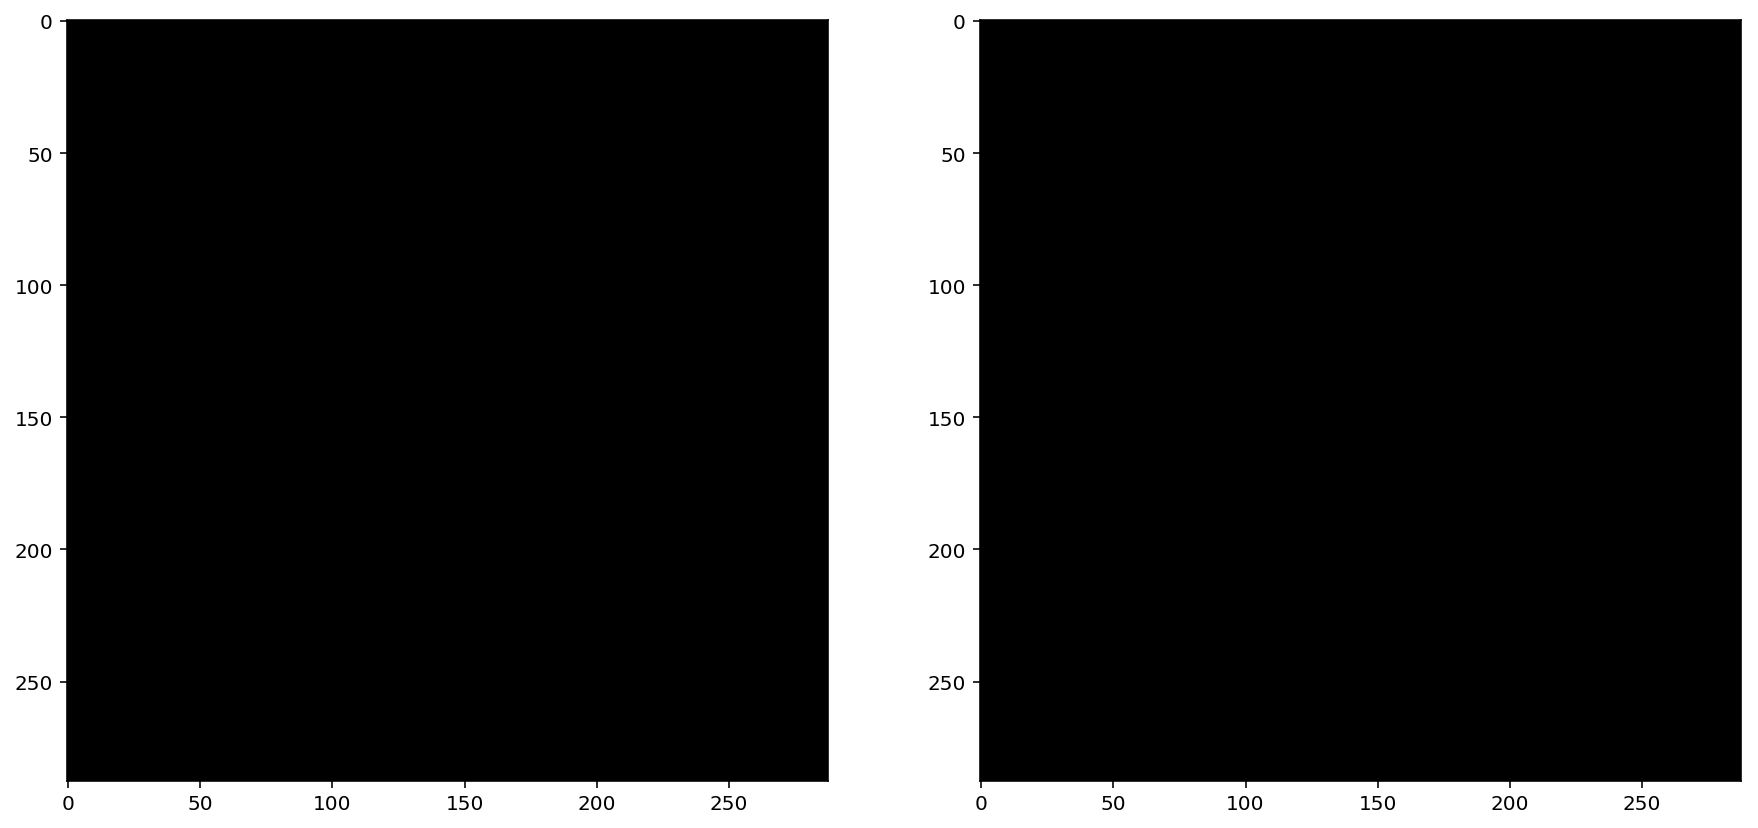

In [51]:
import cv2
from skimage.color import ycbcr2rgb
plt.figure(figsize=(15,15))
for i, image in enumerate([input_,label_]):
    plt.subplot(1,2,i+1)
    w, h = image.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = image[:, :, np.newaxis]
   # imgrgb = ycbcr2rgb(ret)
    plt.imshow(ret)
    print(ret.shape)
    
    
    
    